In [1]:
#Import packages
import numpy as np
from multicontact_learning_local_objectives.python.rhp_plan.rhp_utils import * #Need get Init Config from global frame Function 
import os
import pickle
from multicontact_learning_local_objectives.python.machine_learning.ml_utils import *
import matplotlib.pyplot as plt #Matplotlib
import time
import shutil
import sys
from multicontact_learning_local_objectives.python.rhp_plan.rhp_utils import *

np.set_printoptions(precision=4)

In [2]:
#--------------
#Set up for Directories
#   Define Working Directory
workingDirectory = "/home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep"
print("Working folder: ", workingDirectory)
#   Define Tracking RollOuts Path
TrackingExpPath = workingDirectory + "/" + "NN_TrackTraining_InitialAll"
if not (os.path.isdir(TrackingExpPath)):
    raise Exception("Fault Tracking Exp Path")
else:
    print("Tracking Exp RollOut folder: ", TrackingExpPath)
#   Define Ground Truth RollOuts Path
GroundTruthPath = workingDirectory + "/" + "ReRollOut_TrainingInitialSet_All_InitialSet"
if not (os.path.isdir(GroundTruthPath)):
    raise Exception("Fault Ground Truth RollOut Path")
else:
    print("Ground Truth RollOut folder: ", GroundTruthPath)
    
maxStepIndexbeforeFail = 28
print("We collect Maximum the ", str(maxStepIndexbeforeFail), "-th step before the failed step")


Working folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep
Tracking Exp RollOut folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep/NN_TrackTraining_InitialAll
Ground Truth RollOut folder:  /home/jiayu/Desktop/MLP_DataSet/Rubbles_RegretOneStep/ReRollOut_TrainingInitialSet_All_InitialSet
We collect Maximum the  28 -th step before the failed step


In [3]:
#   Define Number of file proccessed
total_file_num = 0
failed_file_num = 0
success_file_num = 0

#   Get File names in the Local Obj Tracking Exp Folder
GroundTruth_filenames = os.listdir(GroundTruthPath)

success_error_all = []
failed_error_all = []

diff_threshold = 0.04
large_error_cnt = 0

#Loop over all the tracking exp files
for GroundTruth_filename in GroundTruth_filenames:
    
    print(GroundTruth_filename)
    
    if ".p" in GroundTruth_filename:#a data file
        
        #Get Ground Truth Traj
        with open(GroundTruthPath + '/' + GroundTruth_filename, 'rb') as f:
            GroundTruth_data= pickle.load(f)
            
        #Load Tracking Exp data
        #   Get Tracking Exp File name
        TrackingExpFileName_StartingIdx = GroundTruth_data["TerrainModelPath"].find("/Group")
        TrackingExpFileName = GroundTruth_data["TerrainModelPath"][TrackingExpFileName_StartingIdx+1:]
        TrackingExp_file_path = TrackingExpPath + '/' + TrackingExpFileName
    
        #Load Tracking Exp data
        with open(TrackingExp_file_path, 'rb') as f:
            TrackingExp_data= pickle.load(f)
            
        print("Process Tracking Exp File: ",TrackingExpFileName)
        total_file_num = total_file_num + 1 #Process one file
                    
        #Compare Error in the Global Frame (Environment is the same, only compare state)
        if len(TrackingExp_data["SingleOptResultSavings"]) < TrackingExp_data["Num_of_Rounds"] and len(TrackingExp_data["SingleOptResultSavings"]) > 0 and len(GroundTruth_data["SingleOptResultSavings"]) > 0 and len(TrackingExp_data["SingleOptResultSavings"]) == len(GroundTruth_data["SingleOptResultSavings"]): #also need to filter out the cases with 0 step failed
            #Failed Tracking Exp
            print("- Failed Tracking Exp")
            failed_file_num = failed_file_num + 1
            
            #Loop Over all the rounds
            err_list_temp = []
            for beforeFailIdx in range(1, maxStepIndexbeforeFail+1):
                
                roundIdx_of_interst = len(TrackingExp_data["SingleOptResultSavings"])-beforeFailIdx
                
                if roundIdx_of_interst > 0:
                    print(roundIdx_of_interst)
                
                    TrackingExp_SingleOptResult = TrackingExp_data["SingleOptResultSavings"][roundIdx_of_interst]
                    TrackingExp_InitConfig_Temp, TrackingExp_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=TrackingExp_SingleOptResult)
                    TrackingExp_EndState = np.array([TrackingExp_TerminalConfig_Temp["x_end"],TrackingExp_TerminalConfig_Temp["y_end"],TrackingExp_TerminalConfig_Temp["z_end"],
                                                  TrackingExp_TerminalConfig_Temp["xdot_end"],TrackingExp_TerminalConfig_Temp["ydot_end"],TrackingExp_TerminalConfig_Temp["zdot_end"],
                                                  TrackingExp_TerminalConfig_Temp["Lx_end"],TrackingExp_TerminalConfig_Temp["Ly_end"],TrackingExp_TerminalConfig_Temp["Lz_end"],
                                                  TrackingExp_TerminalConfig_Temp["Px"],TrackingExp_TerminalConfig_Temp["Py"],TrackingExp_TerminalConfig_Temp["Pz"],])

                    
                    GroundTruth_SingleOptResult = GroundTruth_data["SingleOptResultSavings"][roundIdx_of_interst]
                    GroundTruth_InitConfig_Temp, GroundTruth_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=GroundTruth_SingleOptResult)
                    GroundTruth_EndState = np.array([GroundTruth_TerminalConfig_Temp["x_end"],GroundTruth_TerminalConfig_Temp["y_end"],GroundTruth_TerminalConfig_Temp["z_end"],
                                                  GroundTruth_TerminalConfig_Temp["xdot_end"],GroundTruth_TerminalConfig_Temp["ydot_end"],GroundTruth_TerminalConfig_Temp["zdot_end"],
                                                  GroundTruth_TerminalConfig_Temp["Lx_end"],GroundTruth_TerminalConfig_Temp["Ly_end"],GroundTruth_TerminalConfig_Temp["Lz_end"],
                                                  GroundTruth_TerminalConfig_Temp["Px"],GroundTruth_TerminalConfig_Temp["Py"],GroundTruth_TerminalConfig_Temp["Pz"],])

                #Compute Error
                error_vec = np.linalg.norm(TrackingExp_EndState - GroundTruth_EndState)
                err_list_temp.append(error_vec)
                
                if error_vec > diff_threshold:
                    large_error_cnt = large_error_cnt + 1
            
            failed_error_all.append(err_list_temp)
            # print(err_list_temp)
            # fig=plt.figure();   ax = fig.gca()
            # plt.plot(err_list_temp)
            # plt.show()
            #             TrackingExp_InitConfig, TrackingExp_TerminalConfig = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=SingleOptResult_n_StepsBeforeFail)

        elif len(TrackingExp_data["SingleOptResultSavings"]) == TrackingExp_data["Num_of_Rounds"] and len(GroundTruth_data["SingleOptResultSavings"]) == len(TrackingExp_data["SingleOptResultSavings"]):
            #Successful Tracking Exp
            print("- Successful Tracking Exp")
            success_file_num = success_file_num + 1

            #Loop Over all the rounds
            err_list_temp = []
            for roundIdx in range(len(TrackingExp_data["SingleOptResultSavings"])):
                TrackingExp_SingleOptResult = TrackingExp_data["SingleOptResultSavings"][roundIdx]
                TrackingExp_InitConfig_Temp, TrackingExp_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=TrackingExp_SingleOptResult)
                TrackingExp_EndState = np.array([TrackingExp_TerminalConfig_Temp["x_end"],TrackingExp_TerminalConfig_Temp["y_end"],TrackingExp_TerminalConfig_Temp["z_end"],
                                                 TrackingExp_TerminalConfig_Temp["xdot_end"],TrackingExp_TerminalConfig_Temp["ydot_end"],TrackingExp_TerminalConfig_Temp["zdot_end"],
                                                 TrackingExp_TerminalConfig_Temp["Lx_end"],TrackingExp_TerminalConfig_Temp["Ly_end"],TrackingExp_TerminalConfig_Temp["Lz_end"],
                                                 TrackingExp_TerminalConfig_Temp["Px"],TrackingExp_TerminalConfig_Temp["Py"],TrackingExp_TerminalConfig_Temp["Pz"]])


                GroundTruth_SingleOptResult = GroundTruth_data["SingleOptResultSavings"][roundIdx]
                GroundTruth_InitConfig_Temp, GroundTruth_TerminalConfig_Temp = getInitConfig_in_GlobalFrame_from_SingleOptResult(SingleOptRes=GroundTruth_SingleOptResult)
                GroundTruth_EndState = np.array([GroundTruth_TerminalConfig_Temp["x_end"],GroundTruth_TerminalConfig_Temp["y_end"],GroundTruth_TerminalConfig_Temp["z_end"],
                                                 GroundTruth_TerminalConfig_Temp["xdot_end"],GroundTruth_TerminalConfig_Temp["ydot_end"],GroundTruth_TerminalConfig_Temp["zdot_end"],
                                                 GroundTruth_TerminalConfig_Temp["Lx_end"],GroundTruth_TerminalConfig_Temp["Ly_end"],GroundTruth_TerminalConfig_Temp["Lz_end"],
                                                 GroundTruth_TerminalConfig_Temp["Px"],GroundTruth_TerminalConfig_Temp["Py"],GroundTruth_TerminalConfig_Temp["Pz"]])

                #Compute Error
                error_vec = np.linalg.norm(TrackingExp_EndState - GroundTruth_EndState)
                err_list_temp.append(error_vec)
                
                if error_vec > diff_threshold:
                    large_error_cnt = large_error_cnt + 1
                    
            print(err_list_temp)
            
            success_error_all.append(err_list_temp)



Group10_temp1634353994.1832376.txt
Group19_temp1634344106.2230241.txt
Group12_temp1634327527.251425.txt
Group18_temp1634304591.5275261.p
Process Tracking Exp File:  Group18_temp1632923852.9711893.p
- Successful Tracking Exp
[array([0.0271]), array([0.0229]), array([0.0174]), array([0.0401]), array([0.0264]), array([0.0141]), array([0.0255]), array([0.0166]), array([0.0235]), array([0.022]), array([0.0196]), array([0.0248]), array([0.0397]), array([0.0217]), array([0.0321]), array([0.0219]), array([0.0814]), array([0.0333]), array([0.0606]), array([0.0183]), array([0.0183]), array([0.0321]), array([0.0468]), array([0.033]), array([0.0098]), array([0.0386]), array([0.0178]), array([0.0151]), array([0.0514]), array([0.0457])]
Group10_temp1634402286.175885.p
Process Tracking Exp File:  Group10_temp1632944380.269395.p
- Successful Tracking Exp
[array([0.02]), array([0.0556]), array([0.0217]), array([0.0372]), array([0.0165]), array([0.0205]), array([0.0123]), array([0.0217]), array([0.0484]

Process Tracking Exp File:  Group8_temp1632922969.5117345.p
- Successful Tracking Exp
[array([0.0099]), array([0.018]), array([0.0136]), array([0.0225]), array([0.0345]), array([0.0481]), array([0.0204]), array([0.0111]), array([0.0354]), array([0.0246]), array([0.0135]), array([0.0143]), array([0.0323]), array([0.0102]), array([0.0175]), array([0.026]), array([0.1202]), array([0.0491]), array([0.023]), array([0.0257]), array([0.0189]), array([0.0234]), array([0.0155]), array([0.0075]), array([0.0404]), array([0.0445]), array([0.0461]), array([0.017]), array([0.0608]), array([0.0326])]
Group1_temp1634350132.3219287.txt
Group13_temp1634313377.8232176.txt
Group7_temp1634291774.1418638.txt
Group2_temp1634334651.22996.p
Process Tracking Exp File:  Group2_temp1632930859.265964.p
- Failed Tracking Exp
5
4
3
2
1
Group15_temp1634402844.8601618.txt
Group19_temp1634388840.1416075.p
Process Tracking Exp File:  Group19_temp1632942718.3341756.p
- Failed Tracking Exp
3
2
1
Group10_temp1634389381.222

[array([0.0276]), array([0.0367]), array([0.0352]), array([0.0193]), array([0.0319]), array([0.0201]), array([0.0196]), array([0.0105]), array([0.0152]), array([0.0359]), array([0.0267]), array([0.0272]), array([0.0319]), array([0.0225]), array([0.0803]), array([0.0189]), array([0.0149]), array([0.0337]), array([0.0392]), array([0.0237]), array([0.0132]), array([0.0165]), array([0.0557]), array([0.0252]), array([0.033]), array([0.039]), array([0.0306]), array([0.0434]), array([0.0262]), array([0.0192])]
Group7_temp1634349668.5621521.p
Process Tracking Exp File:  Group7_temp1632933003.455162.p
- Successful Tracking Exp
[array([0.0283]), array([0.0296]), array([0.0429]), array([0.0161]), array([0.0507]), array([0.0223]), array([0.0274]), array([0.0358]), array([0.0166]), array([0.0133]), array([0.0234]), array([0.0254]), array([0.0197]), array([0.0132]), array([0.0426]), array([0.0182]), array([0.0589]), array([0.0351]), array([0.0384]), array([0.0294]), array([0.0294]), array([0.0364]),

Process Tracking Exp File:  Group2_temp1632921135.2023344.p
- Successful Tracking Exp
[array([0.0914]), array([0.0172]), array([0.0556]), array([0.0384]), array([0.0168]), array([0.0421]), array([0.0219]), array([0.0433]), array([0.0185]), array([0.0233]), array([0.035]), array([0.0229]), array([0.0389]), array([0.0309]), array([0.1103]), array([0.0414]), array([0.0404]), array([0.0211]), array([0.0187]), array([0.0394]), array([0.0147]), array([0.0131]), array([0.014]), array([0.0505]), array([0.0482]), array([0.014]), array([0.0261]), array([0.0218]), array([0.0276]), array([0.0274])]
Group10_temp1634305693.9798455.txt
Group15_temp1634332786.407454.p
Process Tracking Exp File:  Group15_temp1632931954.9371421.p
- Successful Tracking Exp
[array([0.0172]), array([0.0511]), array([0.0152]), array([0.0308]), array([0.0188]), array([0.0151]), array([0.0263]), array([0.0229]), array([0.0481]), array([0.014]), array([0.0278]), array([0.0201]), array([0.0701]), array([0.0937]), array([0.0536]

Process Tracking Exp File:  Group20_temp1632930812.5317383.p
- Successful Tracking Exp
[array([0.0208]), array([0.0454]), array([0.0737]), array([0.1283]), array([0.1168]), array([0.0338]), array([0.0411]), array([0.0222]), array([0.0285]), array([0.0288]), array([0.0141]), array([0.033]), array([0.0213]), array([0.0247]), array([0.033]), array([0.0235]), array([0.0262]), array([0.0234]), array([0.0292]), array([0.0376]), array([0.0353]), array([0.0406]), array([0.0489]), array([0.0242]), array([0.022]), array([0.0302]), array([0.0256]), array([0.0217]), array([0.0491]), array([0.0222])]
Group12_temp1634321177.074024.p
Process Tracking Exp File:  Group12_temp1632928047.387277.p
- Successful Tracking Exp
[array([0.0124]), array([0.0509]), array([0.037]), array([0.0071]), array([0.0325]), array([0.0384]), array([0.0172]), array([0.0131]), array([0.0457]), array([0.0115]), array([0.016]), array([0.0301]), array([0.0168]), array([0.0367]), array([0.0285]), array([0.0588]), array([0.0599]),

[array([0.0183]), array([0.0628]), array([0.0208]), array([0.0256]), array([0.0115]), array([0.0163]), array([0.0234]), array([0.0108]), array([0.0183]), array([0.0343]), array([0.0217]), array([0.0349]), array([0.0211]), array([0.0272]), array([0.0154]), array([0.0368]), array([0.0151]), array([0.0533]), array([0.0254]), array([0.0488]), array([0.0344]), array([0.0211]), array([0.0621]), array([0.0225]), array([0.0238]), array([0.0161]), array([0.0641]), array([0.0317]), array([0.0249]), array([0.0184])]
Group8_temp1634403269.8129137.txt
Group12_temp1634329291.5158143.txt
Group15_temp1634325069.2255564.txt
Group4_temp1634385920.0179005.p
Process Tracking Exp File:  Group4_temp1632944981.288691.p
- Failed Tracking Exp
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group9_temp1634373388.6675057.p
Process Tracking Exp File:  Group9_temp1632943201.281136.p
- Failed Tracking Exp
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group2_temp1634347746.87

Process Tracking Exp File:  Group7_temp1632950922.2139752.p
- Successful Tracking Exp
[array([0.0263]), array([0.06]), array([0.0319]), array([0.0341]), array([0.0256]), array([0.0369]), array([0.0187]), array([0.0607]), array([0.0322]), array([0.0265]), array([0.0393]), array([0.0202]), array([0.0504]), array([0.0222]), array([0.0173]), array([0.0196]), array([0.0292]), array([0.0491]), array([0.0336]), array([0.0244]), array([0.0703]), array([0.0504]), array([0.035]), array([0.0293]), array([0.0234]), array([0.015]), array([0.0199]), array([0.0509]), array([0.0236]), array([0.0248])]
Group11_temp1634377077.8057368.txt
Group18_temp1634400801.6870127.p
Process Tracking Exp File:  Group18_temp1632948731.5955482.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Group4_temp1634392625.2881348.p
Process Tracking Exp File:  Group4_temp1632946408.4486916.p
- Successful Tracking Exp
[array([0.0519]), array([0.0405]), array([0.1998]), array([0.0701]), array([0.1271]), array([0.0349]), array([0.0605]), 

[array([0.0073]), array([0.0301]), array([0.0342]), array([0.0151]), array([0.0282]), array([0.0237]), array([0.0402]), array([0.0464]), array([0.0129]), array([0.0204]), array([0.0253]), array([0.0157]), array([0.0273]), array([0.0297]), array([0.1099]), array([0.045]), array([0.0558]), array([0.0252]), array([0.0482]), array([0.0402]), array([0.0231]), array([0.0204]), array([0.0274]), array([0.019]), array([0.0182]), array([0.0157]), array([0.0383]), array([0.0367]), array([0.0368]), array([0.0488])]
Group6_temp1634393254.9716063.p
Process Tracking Exp File:  Group6_temp1632946827.6195421.p
- Successful Tracking Exp
[array([0.0339]), array([0.0174]), array([0.0811]), array([0.0325]), array([0.0213]), array([0.0565]), array([0.0418]), array([0.0171]), array([0.0423]), array([0.0191]), array([0.0929]), array([0.0317]), array([0.023]), array([0.0225]), array([0.0167]), array([0.0312]), array([0.0177]), array([0.0302]), array([0.0269]), array([0.016]), array([0.0398]), array([0.0469]), 

Process Tracking Exp File:  Group5_temp1632933450.9832885.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Group19_temp1634322371.2400427.txt
Group15_temp1634366600.7572713.p
Process Tracking Exp File:  Group15_temp1632939247.616016.p
- Failed Tracking Exp
5
4
3
2
1
Group5_temp1634386779.4110773.txt
Group4_temp1634371922.1308882.p
Process Tracking Exp File:  Group4_temp1632940571.037438.p
- Failed Tracking Exp
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group17_temp1634396814.886019.p
Process Tracking Exp File:  Group17_temp1632942115.6997573.p
- Successful Tracking Exp
[array([0.0181]), array([0.0418]), array([0.0274]), array([0.0233]), array([0.024]), array([0.0211]), array([0.0431]), array([0.0168]), array([0.0265]), array([0.0199]), array([0.0367]), array([0.0375]), array([0.0197]), array([0.0418]), array([0.0871]), array([0.0298]), array([0.0487]), array([0.0175]), array([0.0303]), array([0.0305]), array([0.021]), array([0.0295]), array([0.0403]), array([0.0207]), array([

Process Tracking Exp File:  Group17_temp1632936844.4123135.p
- Successful Tracking Exp
[array([0.0056]), array([0.0177]), array([0.0211]), array([0.0643]), array([0.0321]), array([0.0542]), array([0.0391]), array([0.0172]), array([0.0268]), array([0.0294]), array([0.0196]), array([0.0288]), array([0.0261]), array([0.0115]), array([0.0111]), array([0.0296]), array([0.0162]), array([0.0272]), array([0.0173]), array([0.019]), array([0.0182]), array([0.0203]), array([0.0107]), array([0.0187]), array([0.0168]), array([0.0157]), array([0.0536]), array([0.0208]), array([0.0295]), array([0.0308])]
Group11_temp1634322197.6591978.p
Process Tracking Exp File:  Group11_temp1632930169.307027.p
- Successful Tracking Exp
[array([0.0116]), array([0.043]), array([0.0394]), array([0.0431]), array([0.0254]), array([0.0298]), array([0.0273]), array([0.0358]), array([0.0302]), array([0.0404]), array([0.0615]), array([0.0118]), array([0.0164]), array([0.0263]), array([0.0168]), array([0.0123]), array([0.015

Process Tracking Exp File:  Group1_temp1632925651.6412969.p
- Successful Tracking Exp
[array([0.0212]), array([0.0439]), array([0.018]), array([0.0676]), array([0.0264]), array([0.0166]), array([0.0296]), array([0.0185]), array([0.056]), array([0.0281]), array([0.1033]), array([0.0174]), array([0.0671]), array([0.0242]), array([0.016]), array([0.016]), array([0.0259]), array([0.0367]), array([0.0346]), array([0.0089]), array([0.0262]), array([0.0282]), array([0.0181]), array([0.0297]), array([0.017]), array([0.0285]), array([0.0284]), array([0.0187]), array([0.0233]), array([0.0379])]
Group19_temp1634340279.1861942.txt
Group17_temp1634396814.886019.txt
Group20_temp1634372816.9619212.txt
Group6_temp1634374118.2028058.p
Process Tracking Exp File:  Group6_temp1632942482.0444405.p
Group12_temp1634346464.6042573.p
Process Tracking Exp File:  Group12_temp1632936071.3490615.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Group4_temp1634375544.6471593.txt
Group10_temp1634407577.1523218.txt
Group15_t

Process Tracking Exp File:  Group12_temp1632933273.8214438.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Group9_temp1634365762.590344.txt
Group11_temp1634360190.9149756.p
Process Tracking Exp File:  Group11_temp1632941330.8572118.p
- Successful Tracking Exp
[array([0.0508]), array([0.0223]), array([0.0174]), array([0.0188]), array([0.0314]), array([0.0379]), array([0.01]), array([0.0281]), array([0.0395]), array([0.0336]), array([0.0264]), array([0.0221]), array([0.013]), array([0.0223]), array([0.026]), array([0.0165]), array([0.0345]), array([0.0146]), array([0.1548]), array([0.0691]), array([0.0762]), array([0.0186]), array([0.0322]), array([0.0347]), array([0.0473]), array([0.0357]), array([0.0229]), array([0.0984]), array([0.0329]), array([0.0399])]
Group1_temp1634364917.3674414.p
Process Tracking Exp File:  Group1_temp1632940511.864325.p
- Successful Tracking Exp
[array([0.0192]), array([0.0205]), array([0.0297]), array([0.0192]), array([0.0358]), array([0.0277]), array([0.0206]), ar

Process Tracking Exp File:  Group17_temp1632937200.4330626.p
- Successful Tracking Exp
[array([0.01]), array([0.0624]), array([0.0172]), array([0.109]), array([0.0171]), array([0.0229]), array([0.0182]), array([0.0461]), array([0.0555]), array([0.0189]), array([0.0181]), array([0.0174]), array([0.1132]), array([0.029]), array([0.0368]), array([0.0449]), array([0.0237]), array([0.023]), array([0.0835]), array([0.0221]), array([0.0178]), array([0.0193]), array([0.0536]), array([0.018]), array([0.1268]), array([0.0312]), array([0.0343]), array([0.0344]), array([0.0336]), array([0.0128])]
Group14_temp1634394113.5581496.p
Process Tracking Exp File:  Group14_temp1632945771.331578.p
- Successful Tracking Exp
[array([0.0152]), array([0.207]), array([0.0903]), array([0.0387]), array([0.0254]), array([0.0242]), array([0.0212]), array([0.0273]), array([0.0442]), array([0.0323]), array([0.0444]), array([0.0389]), array([0.0213]), array([0.0251]), array([0.0162]), array([0.0253]), array([0.0352]), 

[array([0.0157]), array([0.0378]), array([0.0233]), array([0.0331]), array([0.0347]), array([0.0085]), array([0.0504]), array([0.0226]), array([0.0193]), array([0.0303]), array([0.0419]), array([0.0191]), array([0.0378]), array([0.0228]), array([0.0175]), array([0.0392]), array([0.0188]), array([0.0267]), array([0.0189]), array([0.0222]), array([0.02]), array([0.0407]), array([0.0669]), array([0.0734]), array([0.038]), array([0.0288]), array([0.031]), array([0.0267]), array([0.0187]), array([0.0098])]
Group9_temp1634376406.8006148.txt
Group5_temp1634320264.3314867.p
Process Tracking Exp File:  Group5_temp1632925880.6974564.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Group7_temp1634379667.518792.txt
Group16_temp1634297316.2181466.p
Process Tracking Exp File:  Group16_temp1632921036.8286695.p
- Successful Tracking Exp
[array([0.0083]), array([0.0307]), array([0.0083]), array([0.1013]), array([0.0576]), array([0.0234]), array([0.0179]), array([0.0314]), array([0.0711]), array([0.0151]), arr

[array([0.0262]), array([0.062]), array([0.0352]), array([0.0235]), array([0.0209]), array([0.0316]), array([0.0232]), array([0.0124]), array([0.0165]), array([0.0172]), array([0.0229]), array([0.0299]), array([0.0245]), array([0.0198]), array([0.0305]), array([0.0193]), array([0.043]), array([0.0394]), array([0.0408]), array([0.0689]), array([0.0318]), array([0.03]), array([0.0594]), array([0.0276]), array([0.0216]), array([0.0307]), array([0.0574]), array([0.0258]), array([0.0107]), array([0.0225])]
Group17_temp1634342309.555116.p
Process Tracking Exp File:  Group17_temp1632931094.832964.p
- Failed Tracking Exp
1
Group7_temp1634357529.556751.txt
Group10_temp1634384739.5847807.p
Process Tracking Exp File:  Group10_temp1632941186.33607.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group20_temp1634344615.720827.txt
Group12_temp1634397173.3704593.p
Process Tracking Exp File:  Group12_temp1632950795.0768437.p
- Failed Tracking Exp
28
27
26
25
24
23
22

Process Tracking Exp File:  Group13_temp1632923132.4123313.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group12_temp1634365288.8962758.txt
Group1_temp1634327344.5171442.p
Process Tracking Exp File:  Group1_temp1632930337.8487186.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group19_temp1634347439.3741353.txt
Group15_temp1634382577.9444847.p
Process Tracking Exp File:  Group15_temp1632944619.108371.p
- Failed Tracking Exp
9
8
7
6
5
4
3
2
1
Group8_temp1634345511.6858099.p
Process Tracking Exp File:  Group8_temp1632931826.29646.p
- Failed Tracking Exp
6
5
4
3
2
1
Group2_temp1634369621.0868573.p
Process Tracking Exp File:  Group2_temp1632943539.259.p
- Successful Tracking Exp
[array([0.016]), array([0.0528]), array([0.0452]), array([0.0347]), array([0.0329]), array([0.0343]), array([0.0256]), array([0.0296]), array([0.0427]), array([0.02]), array([0.0307]), array([0.0147]), array([0.0186]), array([0.026]), array([0.0342]), array([0.0312]), array([0.0234]), arra

Process Tracking Exp File:  Group6_temp1632921393.056488.p
- Successful Tracking Exp
[array([0.026]), array([0.0511]), array([0.0306]), array([0.0206]), array([0.0139]), array([0.0164]), array([0.0266]), array([0.046]), array([0.0084]), array([0.0162]), array([0.0322]), array([0.0195]), array([0.0208]), array([0.0303]), array([0.0273]), array([0.0368]), array([0.0421]), array([0.0299]), array([0.0291]), array([0.0272]), array([0.023]), array([0.0291]), array([0.8983]), array([0.0619]), array([0.1336]), array([0.0298]), array([0.0263]), array([0.1435]), array([0.015]), array([0.0306])]
Group16_temp1634359739.6100013.p
Process Tracking Exp File:  Group16_temp1632939619.104046.p
- Successful Tracking Exp
[array([0.0181]), array([0.0184]), array([0.025]), array([0.0112]), array([0.0333]), array([0.0209]), array([0.0147]), array([0.0177]), array([0.0439]), array([0.0266]), array([0.0352]), array([0.0241]), array([0.0236]), array([0.0299]), array([0.0168]), array([0.0113]), array([0.0714]), 

Process Tracking Exp File:  Group8_temp1632930941.823858.p
- Successful Tracking Exp
[array([0.051]), array([0.0186]), array([0.0248]), array([0.0214]), array([0.0289]), array([0.031]), array([0.0481]), array([0.0308]), array([0.0187]), array([0.0208]), array([0.0251]), array([0.0179]), array([0.0274]), array([0.0291]), array([0.0231]), array([0.0538]), array([0.0688]), array([0.0328]), array([0.0244]), array([0.0088]), array([0.0207]), array([0.0279]), array([0.0383]), array([0.0129]), array([0.0803]), array([0.0292]), array([0.0633]), array([0.0443]), array([0.0261]), array([0.0157])]
Group12_temp1634329291.5158143.p
Process Tracking Exp File:  Group12_temp1632931709.103065.p
- Successful Tracking Exp
[array([0.0232]), array([0.03]), array([0.0459]), array([0.0206]), array([0.0132]), array([0.0309]), array([0.0193]), array([0.0288]), array([0.038]), array([0.0098]), array([0.0358]), array([0.0228]), array([0.0475]), array([0.0207]), array([0.0444]), array([0.0496]), array([0.021]), a

[array([0.0208]), array([0.0345]), array([0.0198]), array([0.0268]), array([0.0371]), array([0.0361]), array([0.0486]), array([0.0605]), array([0.0324]), array([0.0374]), array([0.0285]), array([0.0124]), array([0.0168]), array([0.0355]), array([0.022]), array([0.0316]), array([0.0316]), array([0.0255]), array([0.0237]), array([0.0142]), array([0.0283]), array([0.0224]), array([0.057]), array([0.0348]), array([0.0157]), array([0.0278]), array([0.0179]), array([0.0288]), array([0.0099]), array([0.0245])]
Group20_temp1634315233.6649761.txt
Group12_temp1634322579.5460515.p
Process Tracking Exp File:  Group12_temp1632928318.2130194.p
- Failed Tracking Exp
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group12_temp1634377922.3290362.txt
Group3_temp1634370025.9631584.p
Process Tracking Exp File:  Group3_temp1632943067.6791127.p
Group17_temp1634317850.0224576.txt
Group12_temp1634369684.435412.txt
Group6_temp1634298040.8588688.txt
Group9_temp1634369332.6947298.txt
Group7_temp1634362904.762

[array([0.0205]), array([0.0193]), array([0.0377]), array([0.029]), array([0.0272]), array([0.015]), array([0.0162]), array([0.0238]), array([0.019]), array([0.0217]), array([0.0234]), array([0.0255]), array([0.0359]), array([0.0808]), array([0.0325]), array([0.0496]), array([0.0635]), array([0.0371]), array([0.0211]), array([0.0213]), array([0.0267]), array([0.0349]), array([0.0118]), array([0.0157]), array([0.0604]), array([0.0177]), array([0.0308]), array([0.0282]), array([0.065]), array([0.0116])]
Group1_temp1634376743.1863515.p
Process Tracking Exp File:  Group1_temp1632942516.5445259.p
- Successful Tracking Exp
[array([0.0246]), array([0.0235]), array([0.0132]), array([0.0101]), array([0.0156]), array([0.0382]), array([0.0198]), array([0.0548]), array([0.037]), array([0.051]), array([0.0158]), array([0.0149]), array([0.0423]), array([0.0325]), array([0.021]), array([0.0296]), array([0.0381]), array([0.0207]), array([0.0268]), array([0.0329]), array([0.0143]), array([0.0356]), arr

5
4
3
2
1
Group10_temp1634375081.0942616.p
Process Tracking Exp File:  Group10_temp1632939204.8386679.p
- Failed Tracking Exp
4
3
2
1
Group18_temp1634357618.550206.txt
Group4_temp1634368727.282872.p
Process Tracking Exp File:  Group4_temp1632939910.7004118.p
- Successful Tracking Exp
[array([0.0196]), array([0.0336]), array([0.0239]), array([0.0201]), array([0.023]), array([0.0148]), array([0.0295]), array([0.0125]), array([0.0263]), array([0.0232]), array([0.026]), array([0.0226]), array([0.036]), array([0.0103]), array([0.0236]), array([0.0427]), array([0.0319]), array([0.031]), array([0.0103]), array([0.0274]), array([0.0115]), array([0.0163]), array([0.0219]), array([0.0326]), array([0.0236]), array([0.0346]), array([0.0238]), array([0.029]), array([0.017]), array([0.0197])]
Group10_temp1634397556.525979.p
Process Tracking Exp File:  Group10_temp1632943474.4706986.p
- Successful Tracking Exp
[array([0.0156]), array([0.0464]), array([0.0302]), array([0.0387]), array([0.022]), array(

Process Tracking Exp File:  Group19_temp1632942625.527419.p
- Successful Tracking Exp
[array([0.0404]), array([0.0209]), array([0.1397]), array([0.0282]), array([0.0183]), array([0.0164]), array([0.046]), array([0.0585]), array([0.1506]), array([0.0477]), array([0.0281]), array([0.0389]), array([0.0204]), array([0.0393]), array([0.085]), array([0.0358]), array([0.0281]), array([0.0261]), array([0.0398]), array([0.0185]), array([0.0208]), array([0.0332]), array([0.0176]), array([0.0242]), array([0.0185]), array([0.0204]), array([0.0342]), array([0.0355]), array([0.0118]), array([0.026])]
Group5_temp1634358782.216656.p
Process Tracking Exp File:  Group5_temp1632936125.098521.p
- Successful Tracking Exp
[array([0.0167]), array([0.0252]), array([0.0249]), array([0.0197]), array([0.0189]), array([0.0372]), array([0.0153]), array([0.034]), array([0.0126]), array([0.0306]), array([0.0497]), array([0.0799]), array([0.1107]), array([0.0321]), array([0.0431]), array([0.027]), array([0.0283]), ar

[array([0.0364]), array([0.0171]), array([0.016]), array([0.0304]), array([0.0153]), array([0.032]), array([0.0095]), array([0.0155]), array([0.027]), array([0.0151]), array([0.0245]), array([0.028]), array([0.0187]), array([0.0311]), array([0.0202]), array([0.0373]), array([0.0129]), array([0.0296]), array([0.0155]), array([0.0177]), array([0.0311]), array([0.0539]), array([0.0891]), array([0.0368]), array([0.144]), array([0.027]), array([0.0435]), array([0.0228]), array([0.0427]), array([0.0355])]
Group18_temp1634334966.490974.txt
Group17_temp1634306176.0544002.txt
Group6_temp1634303323.8380864.txt
Group12_temp1634384388.7110403.txt
Group6_temp1634334575.9741626.p
Process Tracking Exp File:  Group6_temp1632930581.7223701.p
- Successful Tracking Exp
[array([0.0515]), array([0.0286]), array([0.0142]), array([0.0212]), array([0.0207]), array([0.0178]), array([0.0521]), array([0.0511]), array([0.1564]), array([0.0311]), array([0.0496]), array([0.0212]), array([0.0117]), array([0.0292]), 

[array([0.0174]), array([0.0386]), array([0.0257]), array([0.013]), array([0.045]), array([0.0117]), array([0.0347]), array([0.0351]), array([0.0414]), array([0.0235]), array([0.033]), array([0.0289]), array([0.1126]), array([0.0289]), array([0.0724]), array([0.0168]), array([0.0244]), array([0.0235]), array([0.0359]), array([0.0173]), array([0.046]), array([0.0248]), array([0.0582]), array([0.0439]), array([0.0183]), array([0.0243]), array([0.0153]), array([0.0153]), array([0.0274]), array([0.0339])]
Group5_temp1634403984.6811724.p
Process Tracking Exp File:  Group5_temp1632947316.5135052.p
- Successful Tracking Exp
[array([0.0291]), array([0.0207]), array([0.2098]), array([0.0283]), array([0.0154]), array([0.0283]), array([0.0373]), array([0.0626]), array([0.0802]), array([0.0357]), array([0.1784]), array([0.0213]), array([0.0267]), array([0.0372]), array([0.0151]), array([0.0721]), array([0.0516]), array([0.0374]), array([0.0388]), array([0.0398]), array([0.0365]), array([0.0304]), 

Process Tracking Exp File:  Group9_temp1632924466.5896025.p
- Successful Tracking Exp
[array([0.0249]), array([0.0139]), array([0.0382]), array([0.0497]), array([0.0225]), array([0.0298]), array([0.0149]), array([0.0171]), array([0.0337]), array([0.032]), array([0.0412]), array([0.0193]), array([0.0599]), array([0.0327]), array([0.036]), array([0.0197]), array([0.0511]), array([0.0201]), array([0.0691]), array([0.032]), array([0.0394]), array([0.0383]), array([0.043]), array([0.034]), array([0.0442]), array([0.0265]), array([0.0235]), array([0.0402]), array([0.0539]), array([0.0328])]
Group17_temp1634401551.8930643.txt
Group9_temp1634321199.0449352.p
Process Tracking Exp File:  Group9_temp1632928257.5726154.p
- Successful Tracking Exp
[array([0.0119]), array([0.0142]), array([0.0125]), array([0.0626]), array([0.0226]), array([0.039]), array([0.0171]), array([0.0204]), array([0.0221]), array([0.021]), array([0.0489]), array([0.0232]), array([0.025]), array([0.0363]), array([0.0181]), ar

Process Tracking Exp File:  Group11_temp1632929234.49552.p
- Failed Tracking Exp
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group17_temp1634343071.4116266.txt
Group6_temp1634404924.8309102.p
Process Tracking Exp File:  Group6_temp1632948706.8802354.p
- Successful Tracking Exp
[array([0.023]), array([0.0245]), array([0.0134]), array([0.0515]), array([0.018]), array([0.0391]), array([0.0514]), array([0.0094]), array([0.0414]), array([0.0327]), array([0.0103]), array([0.0212]), array([0.0206]), array([0.0117]), array([0.0306]), array([0.027]), array([0.034]), array([0.0304]), array([0.0101]), array([0.0361]), array([0.0285]), array([0.0376]), array([0.0182]), array([0.0183]), array([0.0218]), array([0.0158]), array([0.0202]), array([0.036]), array([0.0142]), array([0.0204])]
Group11_temp1634364140.98353.p
Process Tracking Exp File:  Group11_temp1632942394.1628544.p
- Successful Tracking Exp
[array([0.0255]), array([0.0387]), array([0.0201]), array([0.0538])

[array([0.085]), array([0.0253]), array([0.04]), array([0.0396]), array([0.0207]), array([0.0214]), array([0.0452]), array([0.0135]), array([0.0274]), array([0.0386]), array([0.0285]), array([0.0287]), array([0.0169]), array([0.0492]), array([0.0178]), array([0.0193]), array([0.0204]), array([0.0153]), array([0.0184]), array([0.0237]), array([0.042]), array([0.0343]), array([0.0342]), array([0.0255]), array([0.0129]), array([0.0231]), array([0.0347]), array([0.0209]), array([0.0283]), array([0.0269])]
Group12_temp1634339639.0377824.p
Process Tracking Exp File:  Group12_temp1632934464.9269936.p
- Successful Tracking Exp
[array([0.0122]), array([0.0318]), array([0.0325]), array([0.0294]), array([0.0255]), array([0.0394]), array([0.0714]), array([0.0599]), array([0.0402]), array([0.0371]), array([0.0431]), array([0.0275]), array([0.0484]), array([0.0254]), array([0.0212]), array([0.0358]), array([0.019]), array([0.0159]), array([0.0331]), array([0.0135]), array([0.066]), array([0.0387]), 

[array([0.0259]), array([0.0727]), array([0.0761]), array([0.0438]), array([0.0505]), array([0.0232]), array([0.0185]), array([0.0302]), array([0.0131]), array([0.016]), array([0.0438]), array([0.0189]), array([0.0208]), array([0.0202]), array([0.0408]), array([0.0114]), array([0.0821]), array([0.0169]), array([0.0121]), array([0.0317]), array([0.0174]), array([0.0197]), array([0.0164]), array([0.0326]), array([0.0331]), array([0.022]), array([0.0342]), array([0.0173]), array([0.0194]), array([0.0304])]
Group9_temp1634355224.2734892.p
Process Tracking Exp File:  Group9_temp1632938504.2286747.p
- Successful Tracking Exp
[array([0.0192]), array([0.0199]), array([0.0169]), array([0.0563]), array([0.0211]), array([0.0412]), array([0.0206]), array([0.0526]), array([0.0191]), array([0.0428]), array([0.0224]), array([0.0188]), array([0.0191]), array([0.0114]), array([0.044]), array([0.0252]), array([0.0564]), array([0.0551]), array([0.0248]), array([0.0203]), array([0.0402]), array([0.0407]),

[array([0.0158]), array([0.0216]), array([0.0235]), array([0.0182]), array([0.0648]), array([0.028]), array([0.0359]), array([0.0329]), array([0.0148]), array([0.0302]), array([0.0419]), array([0.0159]), array([0.0537]), array([0.0371]), array([0.07]), array([0.0311]), array([0.0257]), array([0.023]), array([0.016]), array([0.0442]), array([0.0804]), array([0.0281]), array([0.0503]), array([0.0318]), array([0.0245]), array([0.0392]), array([0.0202]), array([0.0193]), array([0.0328]), array([0.027])]
Group9_temp1634335771.5248535.p
Process Tracking Exp File:  Group9_temp1632932502.3553376.p
- Successful Tracking Exp
[array([0.0358]), array([0.0334]), array([0.0265]), array([0.0169]), array([0.0079]), array([0.0236]), array([0.0278]), array([0.0171]), array([0.1433]), array([0.0252]), array([0.0448]), array([0.023]), array([0.016]), array([0.0379]), array([0.0449]), array([0.0213]), array([0.0524]), array([0.0413]), array([0.0373]), array([0.014]), array([0.0269]), array([0.0313]), array

Process Tracking Exp File:  Group1_temp1632939463.2088048.p
- Failed Tracking Exp
3
2
1
Group1_temp1634376743.1863515.txt
Group3_temp1634371687.5588005.p
Process Tracking Exp File:  Group3_temp1632943163.8489456.p
- Successful Tracking Exp
[array([0.0263]), array([0.0241]), array([0.0228]), array([0.0221]), array([0.023]), array([0.052]), array([0.0245]), array([0.0477]), array([0.0117]), array([0.0227]), array([0.0337]), array([0.0288]), array([0.0185]), array([0.0104]), array([0.0404]), array([0.0173]), array([0.0196]), array([0.0128]), array([0.0434]), array([0.0394]), array([0.0258]), array([0.0255]), array([0.0214]), array([0.0645]), array([0.0445]), array([0.0282]), array([0.0671]), array([0.0243]), array([0.0731]), array([0.0401])]
Group19_temp1634371389.2885444.p
Process Tracking Exp File:  Group19_temp1632937193.9917595.p
- Failed Tracking Exp
5
4
3
2
1
Group18_temp1634337845.3563058.txt
Group3_temp1634378099.482417.txt
Group12_temp1634342785.8743331.p
Process Tracking Exp Fil

[array([0.0487]), array([0.0455]), array([0.0789]), array([0.0301]), array([0.0221]), array([0.031]), array([0.0236]), array([0.0289]), array([0.0646]), array([0.0167]), array([0.0306]), array([0.0234]), array([0.0173]), array([0.0129]), array([0.045]), array([0.0265]), array([0.017]), array([0.0323]), array([0.02]), array([0.0198]), array([0.02]), array([0.0183]), array([0.062]), array([0.0242]), array([0.0559]), array([0.028]), array([0.0645]), array([0.0339]), array([0.0203]), array([0.0327])]
Group20_temp1634299866.718092.txt
Group10_temp1634350940.7643824.txt
Group1_temp1634318566.3478696.p
Process Tracking Exp File:  Group1_temp1632927010.8142204.p
- Successful Tracking Exp
[array([0.0084]), array([0.0413]), array([0.0212]), array([0.0116]), array([0.0411]), array([0.024]), array([0.0172]), array([0.0088]), array([0.02]), array([0.0266]), array([0.015]), array([0.0411]), array([0.0309]), array([0.0398]), array([0.0254]), array([0.017]), array([0.0195]), array([0.021]), array([0.0

Process Tracking Exp File:  Group10_temp1632920157.4792728.p
- Successful Tracking Exp
[array([0.0167]), array([0.0165]), array([0.019]), array([0.0504]), array([0.0298]), array([0.0184]), array([0.0185]), array([0.0216]), array([0.0163]), array([0.0225]), array([0.0227]), array([0.0353]), array([0.0259]), array([0.0295]), array([0.0241]), array([0.033]), array([0.0094]), array([0.0315]), array([0.0257]), array([0.0225]), array([0.0304]), array([0.0584]), array([0.0385]), array([0.0264]), array([0.0224]), array([0.0128]), array([0.0304]), array([0.0137]), array([0.0368]), array([0.0376])]
Group1_temp1634293091.8498049.p
Process Tracking Exp File:  Group1_temp1632920709.833719.p
- Successful Tracking Exp
[array([0.025]), array([0.0249]), array([0.1057]), array([0.144]), array([0.1566]), array([0.0516]), array([0.0268]), array([0.0227]), array([0.0184]), array([0.0331]), array([0.0295]), array([0.0225]), array([0.014]), array([0.0219]), array([0.0276]), array([0.0124]), array([0.0524]), 

[array([0.0274]), array([0.0292]), array([0.0722]), array([0.0496]), array([0.0639]), array([0.0478]), array([0.0283]), array([0.0315]), array([0.0245]), array([0.0245]), array([0.0225]), array([0.018]), array([0.039]), array([0.0465]), array([0.0212]), array([0.0474]), array([0.0644]), array([0.0647]), array([0.0388]), array([0.0573]), array([0.031]), array([0.0357]), array([0.0368]), array([0.03]), array([0.0412]), array([0.0415]), array([0.0198]), array([0.0292]), array([0.0392]), array([0.0236])]
Group6_temp1634319126.9500718.p
Process Tracking Exp File:  Group6_temp1632926284.4808254.p
- Successful Tracking Exp
[array([0.0216]), array([0.024]), array([0.0404]), array([0.0231]), array([0.026]), array([0.0171]), array([0.0557]), array([0.0182]), array([0.0606]), array([0.0147]), array([0.0311]), array([0.0211]), array([0.0382]), array([0.0357]), array([0.0245]), array([0.0441]), array([0.0493]), array([0.0359]), array([0.0327]), array([0.0209]), array([0.0271]), array([0.0193]), arr

Process Tracking Exp File:  Group9_temp1632921756.6498494.p
- Successful Tracking Exp
[array([0.0224]), array([0.0272]), array([0.0323]), array([0.037]), array([0.0316]), array([0.0303]), array([0.0233]), array([0.0317]), array([0.0198]), array([0.0403]), array([0.0096]), array([0.0287]), array([0.0448]), array([0.0247]), array([0.042]), array([0.0213]), array([0.0255]), array([0.027]), array([0.0294]), array([0.0185]), array([0.0272]), array([0.0118]), array([0.1738]), array([0.0269]), array([0.0173]), array([0.0173]), array([0.0347]), array([0.052]), array([0.0197]), array([0.0347])]
Group5_temp1634308412.758111.p
Process Tracking Exp File:  Group5_temp1632923018.9007607.p
- Successful Tracking Exp
[array([0.033]), array([0.0517]), array([0.0246]), array([0.0296]), array([0.0178]), array([0.0216]), array([0.0176]), array([0.0415]), array([0.0161]), array([0.0263]), array([0.015]), array([0.0175]), array([0.0116]), array([0.0214]), array([0.0132]), array([0.0293]), array([0.0315]), ar

[array([0.0187]), array([0.0322]), array([0.0323]), array([0.0288]), array([0.0321]), array([0.0167]), array([0.0515]), array([0.0351]), array([0.0491]), array([0.0299]), array([0.069]), array([0.0187]), array([0.0478]), array([0.032]), array([0.0298]), array([0.0211]), array([0.0224]), array([0.038]), array([0.0423]), array([0.017]), array([0.0999]), array([0.0297]), array([0.0304]), array([0.0768]), array([0.15]), array([0.2047]), array([0.0812]), array([0.0187]), array([0.0231]), array([0.0319])]
Group19_temp1634342840.6246576.txt
Group16_temp1634403667.9425108.txt
Group19_temp1634320370.837759.p
Process Tracking Exp File:  Group19_temp1632927541.314871.p
- Successful Tracking Exp
[array([0.0134]), array([0.0181]), array([0.0184]), array([0.0075]), array([0.0097]), array([0.0301]), array([0.0156]), array([0.0333]), array([0.0178]), array([0.0171]), array([0.0187]), array([0.0147]), array([0.0279]), array([0.0062]), array([0.0169]), array([0.0371]), array([0.0147]), array([0.0257]), 

3
2
1
Group4_temp1634341921.2277112.txt
Group1_temp1634289372.5591047.txt
Group19_temp1634379059.1128922.txt
Group1_temp1634354532.8782134.txt
Group3_temp1634331594.9072554.txt
Group13_temp1634351240.7605357.txt
Group9_temp1634322399.866126.p
Process Tracking Exp File:  Group9_temp1632928442.3497446.p
- Successful Tracking Exp
[array([0.0652]), array([0.0319]), array([0.0394]), array([0.0467]), array([0.0317]), array([0.0358]), array([0.0188]), array([0.017]), array([0.034]), array([0.0115]), array([0.029]), array([0.0486]), array([0.0343]), array([0.0231]), array([0.0327]), array([0.1025]), array([0.0283]), array([0.05]), array([0.1177]), array([0.0324]), array([0.0326]), array([0.0398]), array([0.0213]), array([0.0321]), array([0.0444]), array([0.0693]), array([0.0176]), array([0.0198]), array([0.0186]), array([0.0303])]
Group2_temp1634391442.596555.p
Process Tracking Exp File:  Group2_temp1632949482.308311.p
- Failed Tracking Exp
11
10
9
8
7
6
5
4
3
2
1
Group3_temp1634324676.940272.

16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group18_temp1634307620.0382037.p
Process Tracking Exp File:  Group18_temp1632924681.9301903.p
- Successful Tracking Exp
[array([0.0734]), array([0.014]), array([0.029]), array([0.0336]), array([0.0204]), array([0.02]), array([0.0464]), array([0.0318]), array([0.0146]), array([0.0193]), array([0.0142]), array([0.0293]), array([0.031]), array([0.0118]), array([0.0224]), array([0.0144]), array([0.0361]), array([0.0223]), array([0.0193]), array([0.0185]), array([0.0138]), array([0.0367]), array([0.0307]), array([0.0323]), array([0.0324]), array([0.0767]), array([0.0258]), array([0.014]), array([0.043]), array([0.0242])]
Group8_temp1634343989.6024497.p
Process Tracking Exp File:  Group8_temp1632931130.4669714.p
- Failed Tracking Exp
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group6_temp1634330859.6058142.txt
Group1_temp1634333014.179915.p
Process Tracking Exp File:  Group1_temp1632932380.0468097.p
- Successful Tracking Exp
[ar

6
5
4
3
2
1
Group13_temp1634355380.3998983.p
Process Tracking Exp File:  Group13_temp1632939651.4732206.p
- Successful Tracking Exp
[array([0.0151]), array([0.0384]), array([0.0251]), array([0.0197]), array([0.0305]), array([0.0433]), array([0.0404]), array([0.0256]), array([0.0301]), array([0.0413]), array([0.0296]), array([0.0469]), array([0.0377]), array([0.0209]), array([0.0187]), array([0.0185]), array([0.016]), array([0.0221]), array([0.0342]), array([0.0351]), array([0.0726]), array([0.0232]), array([0.0156]), array([0.0216]), array([0.0347]), array([0.0398]), array([0.0449]), array([0.0139]), array([0.0381]), array([0.0287])]
Group9_temp1634304334.9885035.txt
Group16_temp1634404705.3152804.p
Process Tracking Exp File:  Group16_temp1632950430.0951455.p
- Failed Tracking Exp
1
Group18_temp1634321534.8419998.txt
Group5_temp1634334750.8377047.p
Process Tracking Exp File:  Group5_temp1632929914.7819185.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group4_temp1634343986

[array([0.0202]), array([0.01]), array([0.0306]), array([0.0373]), array([0.0146]), array([0.0343]), array([0.0256]), array([0.0083]), array([0.0658]), array([0.0271]), array([0.0309]), array([0.0301]), array([0.0272]), array([0.0351]), array([0.039]), array([0.0393]), array([0.027]), array([0.0181]), array([0.025]), array([0.0165]), array([0.0182]), array([0.0199]), array([0.0239]), array([0.0171]), array([0.0256]), array([0.0221]), array([0.0313]), array([0.0431]), array([0.0326]), array([0.0531])]
Group18_temp1634390020.7113855.txt
Group17_temp1634338088.5806944.txt
Group20_temp1634331679.8182144.txt
Group1_temp1634337851.249057.txt
Group9_temp1634321199.0449352.txt
Group11_temp1634305147.659183.p
Process Tracking Exp File:  Group11_temp1632923404.6707191.p
- Failed Tracking Exp
2
1
Group9_temp1634326656.3699243.txt
Group4_temp1634352013.4112916.p
Process Tracking Exp File:  Group4_temp1632935481.721706.p
- Successful Tracking Exp
[array([0.0179]), array([0.0233]), array([0.0186]), 

6
5
4
3
2
1
Group17_temp1634309218.1692982.p
Process Tracking Exp File:  Group17_temp1632924846.2251737.p
- Failed Tracking Exp
3
2
1
Group8_temp1634392463.7935724.txt
Group11_temp1634346704.3920598.p
Process Tracking Exp File:  Group11_temp1632936346.7278838.p
- Failed Tracking Exp
7
6
5
4
3
2
1
Group11_temp1634299314.6325781.txt
Group8_temp1634348208.4156415.txt
Group1_temp1634397300.6428258.txt
Group18_temp1634387116.5182774.p
Process Tracking Exp File:  Group18_temp1632942736.404893.p
Group17_temp1634405804.6980505.p
Process Tracking Exp File:  Group17_temp1632944690.6256943.p
- Failed Tracking Exp
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group7_temp1634322812.7531707.p
Process Tracking Exp File:  Group7_temp1632927710.6561146.p
- Successful Tracking Exp
[array([0.0116]), array([0.0292]), array([0.0294]), array([0.0542]), array([0.0307]), array([0.0256]), array([0.0346]), array([0.0478]), array([0.0167]), array([0.0347]), array([0.0198]), array([0.0277])

12
11
10
9
8
7
6
5
4
3
2
1
Group6_temp1634327039.6599488.p
Process Tracking Exp File:  Group6_temp1632928846.041104.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group12_temp1634390079.6369338.p
Process Tracking Exp File:  Group12_temp1632948873.5304382.p
- Successful Tracking Exp
[array([0.0135]), array([0.0392]), array([0.0385]), array([0.0236]), array([0.0617]), array([0.0222]), array([0.0335]), array([0.0328]), array([0.0297]), array([0.0163]), array([0.0242]), array([0.0296]), array([0.0164]), array([0.0192]), array([0.0102]), array([0.0095]), array([0.0187]), array([0.0199]), array([0.0168]), array([0.0164]), array([0.0098]), array([0.0102]), array([0.023]), array([0.0268]), array([0.0401]), array([0.0412]), array([0.0213]), array([0.0263]), array([0.037]), array([0.0242])]
Group1_temp1634331347.721196.p
Process Tracking Exp File:  Group1_temp1632931882.155297.p
- Successful Tracking Exp
[array([0.0449]), array([0.0222]), array([0.0177]), array([0.045]), array([0.01

18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group14_temp1634336783.881228.p
Process Tracking Exp File:  Group14_temp1632934243.3048415.p
- Successful Tracking Exp
[array([0.084]), array([0.0233]), array([0.0243]), array([0.034]), array([0.0094]), array([0.0184]), array([0.0267]), array([0.0186]), array([0.0531]), array([0.0193]), array([0.0178]), array([0.0503]), array([0.0335]), array([0.0187]), array([0.03]), array([0.0133]), array([0.0485]), array([0.02]), array([0.0317]), array([0.0265]), array([0.1027]), array([0.0492]), array([0.016]), array([0.036]), array([0.02]), array([0.0229]), array([0.0416]), array([0.0498]), array([0.0164]), array([0.0245])]
Group10_temp1634391313.4190133.p
Process Tracking Exp File:  Group10_temp1632942187.361458.p
- Successful Tracking Exp
[array([0.0378]), array([0.0333]), array([0.1175]), array([0.081]), array([0.0377]), array([0.0252]), array([0.0426]), array([0.0632]), array([0.1589]), array([0.0285]), array([0.0141]), array([0.0276]), array([0.028

Process Tracking Exp File:  Group2_temp1632945529.2436655.p
Group5_temp1634327778.9118755.p
Process Tracking Exp File:  Group5_temp1632928247.8966005.p
- Successful Tracking Exp
[array([0.0215]), array([0.0343]), array([0.0209]), array([0.0157]), array([0.0289]), array([0.0182]), array([0.0155]), array([0.0168]), array([0.0283]), array([0.0306]), array([0.0201]), array([0.0194]), array([0.019]), array([0.0201]), array([0.1226]), array([0.0807]), array([0.0543]), array([0.0445]), array([0.0282]), array([0.0643]), array([0.0334]), array([0.0231]), array([0.0528]), array([0.0242]), array([0.0445]), array([0.0163]), array([0.135]), array([0.0507]), array([0.0547]), array([0.0509])]
Group14_temp1634317068.54532.txt
Group13_temp1634367970.3413584.p
Process Tracking Exp File:  Group13_temp1632943011.2504325.p
- Successful Tracking Exp
[array([0.0144]), array([0.0557]), array([0.0153]), array([0.0223]), array([0.0135]), array([0.018]), array([0.0362]), array([0.0159]), array([0.028]), array([0

Process Tracking Exp File:  Group12_temp1632929503.629873.p
- Failed Tracking Exp
12
11
10
9
8
7
6
5
4
3
2
1
Group2_temp1634388322.6862195.txt
Group7_temp1634361837.980598.txt
Group10_temp1634328303.2817745.p
Process Tracking Exp File:  Group10_temp1632929261.2701685.p
- Successful Tracking Exp
[array([0.0523]), array([0.0231]), array([0.0508]), array([0.0226]), array([0.0179]), array([0.0216]), array([0.0249]), array([0.0121]), array([0.2826]), array([0.0283]), array([0.0138]), array([0.0251]), array([0.0355]), array([0.0239]), array([0.0996]), array([0.0249]), array([0.0234]), array([0.0111]), array([0.0707]), array([0.0302]), array([0.0319]), array([0.0376]), array([0.0526]), array([0.0231]), array([0.0507]), array([0.0296]), array([0.0238]), array([0.031]), array([0.0209]), array([0.0207])]
Group5_temp1634398014.9717383.txt
Group17_temp1634371500.0694668.txt
Group13_temp1634309212.7269895.txt
Group13_temp1634300588.547319.txt
Group20_temp1634292369.7965322.p
Process Tracking Exp Fi

Process Tracking Exp File:  Group18_temp1632948341.3214915.p
- Successful Tracking Exp
[array([0.0114]), array([0.0213]), array([0.0676]), array([0.0286]), array([0.0377]), array([0.0273]), array([0.0359]), array([0.0235]), array([0.0189]), array([0.0321]), array([0.0216]), array([0.0285]), array([0.0439]), array([0.0315]), array([0.0286]), array([0.04]), array([0.0181]), array([0.0273]), array([0.0114]), array([0.0206]), array([0.0091]), array([0.0265]), array([0.072]), array([0.018]), array([0.0239]), array([0.027]), array([0.0157]), array([0.0214]), array([0.0154]), array([0.0201])]
Group17_temp1634393933.8588428.txt
Group5_temp1634377943.2173295.p
Process Tracking Exp File:  Group5_temp1632941384.0695224.p
- Successful Tracking Exp
[array([0.0264]), array([0.0612]), array([0.0253]), array([0.0335]), array([0.0305]), array([0.038]), array([0.0527]), array([0.0249]), array([0.0234]), array([0.027]), array([0.0215]), array([0.0168]), array([0.0249]), array([0.0229]), array([0.0323]), 

[array([0.1138]), array([0.4294]), array([0.1072]), array([0.0456]), array([0.0162]), array([0.0421]), array([0.0213]), array([0.0169]), array([0.0146]), array([0.015]), array([0.0477]), array([0.033]), array([0.0299]), array([0.1354]), array([0.0488]), array([0.0155]), array([0.0421]), array([0.0221]), array([0.0471]), array([0.0223]), array([0.0239]), array([0.023]), array([0.0215]), array([0.0189]), array([0.0129]), array([0.0425]), array([0.0204]), array([0.0174]), array([0.0373]), array([0.0239])]
Group18_temp1634294996.0192268.txt
Group8_temp1634315141.6139808.p
Process Tracking Exp File:  Group8_temp1632925320.9553323.p
- Successful Tracking Exp
[array([0.0332]), array([0.0255]), array([0.0401]), array([0.0171]), array([0.0335]), array([0.0304]), array([0.0171]), array([0.0482]), array([0.0174]), array([0.0544]), array([0.0202]), array([0.0729]), array([0.0449]), array([0.0407]), array([0.0327]), array([0.0377]), array([0.0161]), array([0.0233]), array([0.0488]), array([0.0235])

[array([0.0272]), array([0.0343]), array([0.0101]), array([0.0199]), array([0.0316]), array([0.0356]), array([0.0226]), array([0.0253]), array([0.0242]), array([0.0235]), array([0.0266]), array([0.038]), array([0.0259]), array([0.0209]), array([0.0149]), array([0.0331]), array([0.0308]), array([0.0366]), array([0.0277]), array([0.0257]), array([0.0356]), array([0.0247]), array([0.024]), array([0.0342]), array([0.011]), array([0.0277]), array([0.0489]), array([0.0293]), array([0.0188]), array([0.0201])]
Group14_temp1634358974.7537603.p
Process Tracking Exp File:  Group14_temp1632939133.1704688.p
Group4_temp1634391416.4057534.p
Process Tracking Exp File:  Group4_temp1632945849.8892028.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Group19_temp1634373851.0843842.txt
Group9_temp1634372526.1384332.p
Process Tracking Exp File:  Group9_temp1632942918.30784.p
- Successful Tracking Exp
[array([0.0132]), array([0.0334]), array([0.0292]), array([0.0775]), array([0.0606]), array([0.0932]), 

Process Tracking Exp File:  Group12_temp1632947496.8660393.p
- Successful Tracking Exp
[array([0.0563]), array([0.0254]), array([0.0214]), array([0.0366]), array([0.0251]), array([0.0289]), array([0.0203]), array([0.0315]), array([0.0287]), array([0.0206]), array([0.0218]), array([0.0384]), array([0.021]), array([0.0287]), array([0.0149]), array([0.022]), array([0.0265]), array([0.0236]), array([0.0413]), array([0.0255]), array([0.0357]), array([0.0163]), array([0.0195]), array([0.0307]), array([0.0128]), array([0.0385]), array([0.0435]), array([0.0405]), array([0.0076]), array([0.0301])]
Group19_temp1634352628.7828557.txt
Group8_temp1634322393.7927768.p
Process Tracking Exp File:  Group8_temp1632926361.8208802.p
- Successful Tracking Exp
[array([0.0559]), array([0.0235]), array([0.0198]), array([0.0155]), array([0.0168]), array([0.0339]), array([0.0561]), array([0.0592]), array([0.0605]), array([0.0248]), array([0.0188]), array([0.0153]), array([0.0347]), array([0.0241]), array([0.017

Process Tracking Exp File:  Group12_temp1632952163.3113103.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group3_temp1634358862.9185152.txt
Group20_temp1634296929.5633214.p
Process Tracking Exp File:  Group20_temp1632921961.107084.p
- Successful Tracking Exp
[array([0.0133]), array([0.0192]), array([0.0322]), array([0.0282]), array([0.041]), array([0.041]), array([0.098]), array([0.0164]), array([0.0161]), array([0.0256]), array([0.0437]), array([0.0289]), array([0.0511]), array([0.0263]), array([0.0793]), array([0.027]), array([0.0211]), array([0.0255]), array([0.0215]), array([0.0202]), array([0.0266]), array([0.0187]), array([0.0235]), array([0.0248]), array([0.0249]), array([0.0212]), array([0.0227]), array([0.0172]), array([0.0383]), array([0.0171])]
Group14_temp1634340229.7684424.p
Process Tracking Exp File:  Group14_temp1632934692.6446657.p
- Failed Tracking Exp
10
9
8
7
6
5
4
3
2
1
Group5_temp1634358782.216656.txt
Group16_temp1634326264.4316

[array([0.0417]), array([0.2219]), array([0.056]), array([0.0312]), array([0.0188]), array([0.0423]), array([0.0349]), array([0.0164]), array([0.0124]), array([0.0281]), array([0.0493]), array([0.0181]), array([0.0717]), array([0.0244]), array([0.0212]), array([0.0203]), array([0.0235]), array([0.0376]), array([0.0191]), array([0.0219]), array([0.069]), array([0.0497]), array([0.08]), array([0.0375]), array([0.0571]), array([0.0155]), array([0.191]), array([0.016]), array([0.0123]), array([0.028])]
Group16_temp1634345201.6219897.txt
Group20_temp1634289133.598379.txt
Group5_temp1634370357.165222.txt
Group12_temp1634350503.9505196.p
Process Tracking Exp File:  Group12_temp1632937561.0298169.p
- Successful Tracking Exp
[array([0.0806]), array([0.011]), array([0.0267]), array([0.0386]), array([0.0283]), array([0.055]), array([0.0124]), array([0.0229]), array([0.0134]), array([0.0203]), array([0.0155]), array([0.0282]), array([0.0129]), array([0.046]), array([0.0263]), array([0.0255]), arra

Process Tracking Exp File:  Group10_temp1632944284.2125893.p
- Successful Tracking Exp
[array([0.0145]), array([0.0245]), array([0.0218]), array([0.0649]), array([0.0267]), array([0.0213]), array([0.0124]), array([0.0251]), array([0.0323]), array([0.0391]), array([0.0284]), array([0.0291]), array([0.0225]), array([0.0228]), array([0.0264]), array([0.0238]), array([0.0094]), array([0.0225]), array([0.0125]), array([0.0256]), array([0.045]), array([0.0268]), array([0.0326]), array([0.0269]), array([0.0166]), array([0.0256]), array([0.019]), array([0.0221]), array([0.0331]), array([0.0434])]
Group17_temp1634342421.9990816.p
Process Tracking Exp File:  Group17_temp1632931315.0907676.p
- Successful Tracking Exp
[array([0.0193]), array([0.0138]), array([0.0143]), array([0.0228]), array([0.0242]), array([0.0316]), array([0.014]), array([0.0255]), array([0.0383]), array([0.0272]), array([0.0415]), array([0.1214]), array([0.0246]), array([0.0289]), array([0.0152]), array([0.0201]), array([0.020

Process Tracking Exp File:  Group6_temp1632941759.9780269.p
- Successful Tracking Exp
[array([0.0068]), array([0.0175]), array([0.0233]), array([0.0302]), array([0.0162]), array([0.0466]), array([0.0199]), array([0.0422]), array([0.0196]), array([0.0267]), array([0.0167]), array([0.0366]), array([0.0185]), array([0.064]), array([0.0313]), array([0.0329]), array([0.0183]), array([0.0123]), array([0.0212]), array([0.0236]), array([0.0227]), array([0.0356]), array([0.03]), array([0.0185]), array([0.0283]), array([0.0396]), array([0.0344]), array([0.0504]), array([0.04]), array([0.0326])]
Group5_temp1634348789.7459552.txt
Group3_temp1634339843.6668544.p
Process Tracking Exp File:  Group3_temp1632935919.846311.p
- Successful Tracking Exp
[array([0.0626]), array([0.0253]), array([0.0336]), array([0.0558]), array([0.0341]), array([0.0542]), array([0.0237]), array([0.035]), array([0.0303]), array([0.0272]), array([0.0374]), array([0.0592]), array([0.0392]), array([0.0339]), array([0.0216]), ar

[array([0.0172]), array([0.0363]), array([0.0157]), array([0.0212]), array([0.052]), array([0.0177]), array([0.015]), array([0.0394]), array([0.0156]), array([0.0224]), array([0.0244]), array([0.0408]), array([0.0213]), array([0.0177]), array([0.0532]), array([0.0249]), array([0.0194]), array([0.0167]), array([0.0159]), array([0.0163]), array([0.0174]), array([0.0266]), array([0.065]), array([0.0162]), array([0.0295]), array([0.0232]), array([0.0222]), array([0.0364]), array([0.0225]), array([0.0309])]
Group14_temp1634303301.525514.p
Process Tracking Exp File:  Group14_temp1632925805.7969441.p
- Failed Tracking Exp
3
2
1
Group17_temp1634323212.174015.p
Process Tracking Exp File:  Group17_temp1632927419.6151826.p
- Successful Tracking Exp
[array([0.0094]), array([0.0624]), array([0.0203]), array([0.0231]), array([0.0122]), array([0.0439]), array([0.0371]), array([0.0226]), array([0.0182]), array([0.0201]), array([0.0119]), array([0.027]), array([0.0208]), array([0.0238]), array([0.0195]

[array([0.0259]), array([0.0173]), array([0.0154]), array([0.0281]), array([0.0203]), array([0.0189]), array([0.0166]), array([0.0255]), array([0.0295]), array([0.0183]), array([0.0297]), array([0.0334]), array([0.0253]), array([0.0332]), array([0.0709]), array([0.0764]), array([0.0332]), array([0.0257]), array([0.0451]), array([0.017]), array([0.0415]), array([0.0366]), array([0.0333]), array([0.027]), array([0.0532]), array([0.0279]), array([0.0159]), array([0.0407]), array([0.0198]), array([0.03])]
Group15_temp1634321694.4286432.p
Process Tracking Exp File:  Group15_temp1632929575.1395426.p
- Successful Tracking Exp
[array([0.008]), array([0.0487]), array([0.0166]), array([0.0458]), array([0.0251]), array([0.0557]), array([0.0152]), array([0.0382]), array([0.0297]), array([0.0528]), array([0.0316]), array([0.0466]), array([0.0303]), array([0.0407]), array([0.0154]), array([0.0306]), array([0.0157]), array([0.0192]), array([0.0603]), array([0.0161]), array([0.0208]), array([0.0187]),

Process Tracking Exp File:  Group8_temp1632942141.7310634.p
- Successful Tracking Exp
[array([0.0477]), array([0.0702]), array([0.0264]), array([0.292]), array([0.0509]), array([0.0217]), array([0.0451]), array([0.0268]), array([0.0251]), array([0.0515]), array([0.074]), array([0.0368]), array([0.0289]), array([0.0234]), array([0.0372]), array([0.0257]), array([0.0297]), array([0.0233]), array([0.0466]), array([0.0365]), array([0.0348]), array([0.053]), array([0.0173]), array([0.0304]), array([0.0229]), array([0.0285]), array([0.0191]), array([0.0352]), array([0.0621]), array([0.0238])]
Group10_temp1634394711.3226097.p
Process Tracking Exp File:  Group10_temp1632942908.1263072.p
- Successful Tracking Exp
[array([0.0266]), array([0.0395]), array([0.0491]), array([0.0439]), array([0.0163]), array([0.0337]), array([0.022]), array([0.0309]), array([0.0347]), array([0.0182]), array([0.0127]), array([0.0258]), array([0.0177]), array([0.0158]), array([0.0296]), array([0.0172]), array([0.0239]

Process Tracking Exp File:  Group11_temp1632942666.5959227.p
- Failed Tracking Exp
12
11
10
9
8
7
6
5
4
3
2
1
Group13_temp1634311195.474409.txt
Group5_temp1634403552.2995915.p
Process Tracking Exp File:  Group5_temp1632947236.0755847.p
- Successful Tracking Exp
[array([0.0231]), array([0.0324]), array([0.0418]), array([0.0461]), array([0.0321]), array([0.0495]), array([0.022]), array([0.0338]), array([0.0247]), array([0.0138]), array([0.0501]), array([0.0172]), array([0.0173]), array([0.0362]), array([0.0311]), array([0.0311]), array([0.0552]), array([0.036]), array([0.0263]), array([0.0332]), array([0.016]), array([0.0107]), array([0.0268]), array([0.029]), array([0.0341]), array([0.0331]), array([0.0329]), array([0.0298]), array([0.0214]), array([0.0192])]
Group5_temp1634325057.060781.p
Process Tracking Exp File:  Group5_temp1632926816.681216.p
- Successful Tracking Exp
[array([0.032]), array([0.0399]), array([0.0222]), array([0.0147]), array([0.0655]), array([0.0405]), array([0.0294

Process Tracking Exp File:  Group15_temp1632947971.064958.p
- Successful Tracking Exp
[array([0.1038]), array([0.0253]), array([0.0847]), array([0.0311]), array([0.056]), array([0.0149]), array([0.0291]), array([0.0311]), array([0.0171]), array([0.0171]), array([0.0532]), array([0.0227]), array([0.0232]), array([0.0192]), array([0.0329]), array([0.0278]), array([0.0251]), array([0.025]), array([0.0526]), array([0.0346]), array([0.0314]), array([0.0345]), array([0.0181]), array([0.0202]), array([0.0426]), array([0.0275]), array([0.0401]), array([0.0341]), array([0.0158]), array([0.0088])]
Group19_temp1634393926.3097677.p
Process Tracking Exp File:  Group19_temp1632943977.8957474.p
- Successful Tracking Exp
[array([0.025]), array([0.0274]), array([0.0492]), array([0.0472]), array([0.0168]), array([0.0558]), array([0.0275]), array([0.0155]), array([0.0416]), array([0.0194]), array([0.0578]), array([0.0107]), array([0.0307]), array([0.0165]), array([0.0936]), array([0.0762]), array([0.0505

23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group16_temp1634365540.2267215.p
Process Tracking Exp File:  Group16_temp1632940395.8040185.p
- Successful Tracking Exp
[array([0.0723]), array([0.0285]), array([0.0217]), array([0.0508]), array([0.04]), array([0.0419]), array([0.0175]), array([0.0242]), array([0.0379]), array([0.0325]), array([0.0268]), array([0.0275]), array([0.0236]), array([0.0422]), array([0.0305]), array([0.0361]), array([0.0188]), array([0.0346]), array([0.0213]), array([0.0349]), array([0.0217]), array([0.0135]), array([0.028]), array([0.019]), array([0.0285]), array([0.0174]), array([0.0217]), array([0.0289]), array([0.012]), array([0.0179])]
Group9_temp1634385759.900994.txt
Group15_temp1634356317.2092378.p
Process Tracking Exp File:  Group15_temp1632936396.820188.p
- Failed Tracking Exp
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group17_temp1634402422.103848.p
Process Tracking Exp File:  Group17_temp1632943809.546805.p
- Successful Tracking Exp
[array

Process Tracking Exp File:  Group20_temp1632931302.4879477.p
- Successful Tracking Exp
[array([0.0266]), array([0.0249]), array([0.0202]), array([0.011]), array([0.013]), array([0.0131]), array([0.0105]), array([0.0331]), array([0.0237]), array([0.0267]), array([0.0335]), array([0.0263]), array([0.0292]), array([0.0311]), array([0.0252]), array([0.0208]), array([0.0166]), array([0.2654]), array([0.0199]), array([0.0277]), array([0.0128]), array([0.0299]), array([0.1885]), array([0.0355]), array([0.0227]), array([0.0406]), array([0.0212]), array([0.0164]), array([0.0303]), array([0.0412])]
Group15_temp1634366794.962976.p
Process Tracking Exp File:  Group15_temp1632939441.2586484.p
- Failed Tracking Exp
5
4
3
2
1
Group10_temp1634288964.809361.txt
Group12_temp1634381195.5278955.p
Process Tracking Exp File:  Group12_temp1632946863.5105026.p
- Successful Tracking Exp
[array([0.0834]), array([0.0452]), array([0.1308]), array([0.0471]), array([0.0851]), array([0.0264]), array([0.0196]), array

[array([0.0174]), array([0.0278]), array([0.0417]), array([0.0183]), array([0.0331]), array([0.021]), array([0.0263]), array([0.0299]), array([0.0337]), array([0.0382]), array([0.0191]), array([0.0471]), array([0.078]), array([0.0125]), array([0.0532]), array([0.0286]), array([0.0188]), array([0.0171]), array([0.0366]), array([0.0313]), array([0.0144]), array([0.035]), array([0.0199]), array([0.0108]), array([0.0442]), array([0.0312]), array([0.0283]), array([0.0205]), array([0.0273]), array([0.051])]
Group16_temp1634326622.7228646.txt
Group18_temp1634345266.9277828.p
Process Tracking Exp File:  Group18_temp1632932777.547382.p
- Successful Tracking Exp
[array([0.031]), array([0.0535]), array([0.024]), array([0.0973]), array([0.0544]), array([0.0178]), array([0.0256]), array([0.0404]), array([0.0489]), array([0.0379]), array([0.0385]), array([0.0153]), array([0.0383]), array([0.0603]), array([0.0868]), array([0.0282]), array([0.039]), array([0.0325]), array([0.033]), array([0.0179]), ar

Process Tracking Exp File:  Group12_temp1632925091.8751907.p
- Successful Tracking Exp
[array([0.0289]), array([0.025]), array([0.0168]), array([0.0486]), array([0.0319]), array([0.0308]), array([0.0121]), array([0.0264]), array([0.047]), array([0.0407]), array([0.0369]), array([0.0236]), array([0.0252]), array([0.015]), array([0.0219]), array([0.0142]), array([0.0158]), array([0.0273]), array([0.0163]), array([0.0134]), array([0.0501]), array([0.0179]), array([0.0171]), array([0.0399]), array([0.0546]), array([0.0239]), array([0.0238]), array([0.0584]), array([0.0154]), array([0.0301])]
Group9_temp1634395442.2987916.p
Process Tracking Exp File:  Group9_temp1632949546.3677897.p
- Successful Tracking Exp
[array([0.0313]), array([0.0386]), array([0.0226]), array([0.0319]), array([0.0217]), array([0.0315]), array([0.0414]), array([0.0276]), array([0.0233]), array([0.0291]), array([0.0229]), array([0.023]), array([0.0167]), array([0.0517]), array([0.0373]), array([0.0262]), array([0.0151])

Process Tracking Exp File:  Group18_temp1632920539.2516603.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group15_temp1634340240.6208494.p
Process Tracking Exp File:  Group15_temp1632933245.4069014.p
- Successful Tracking Exp
[array([0.0713]), array([0.1122]), array([0.1803]), array([0.2294]), array([0.0288]), array([0.0264]), array([0.0172]), array([0.0405]), array([0.0171]), array([0.0347]), array([0.0249]), array([0.0175]), array([0.013]), array([0.0141]), array([0.0218]), array([0.0089]), array([0.0205]), array([0.1]), array([0.0146]), array([0.0155]), array([0.071]), array([0.0098]), array([0.0097]), array([0.0274]), array([0.0222]), array([0.0482]), array([0.0227]), array([0.0109]), array([0.0196]), array([0.0224])]
Group16_temp1634294844.2865202.p
Process Tracking Exp File:  Group16_temp1632920773.2325869.p
- Successful Tracking Exp
[array([0.025]), array([0.0249]), array([0.0785]), array([0.016]), array([0.023]), array([0.013]), array([0.018

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group18_temp1634322336.341853.txt
Group8_temp1634343989.6024497.txt
Group17_temp1634354600.9529154.txt
Group7_temp1634381753.5227804.txt
Group17_temp1634336310.7276452.txt
Group15_temp1634383001.5477607.p
Process Tracking Exp File:  Group15_temp1632944869.3455834.p
- Failed Tracking Exp
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group14_temp1634380263.194209.p
Process Tracking Exp File:  Group14_temp1632943309.9980824.p
- Successful Tracking Exp
[array([0.015]), array([0.0181]), array([0.0222]), array([0.031]), array([0.0322]), array([0.0331]), array([0.0177]), array([0.0421]), array([0.0251]), array([0.0176]), array([0.0408]), array([0.0251]), array([0.0465]), array([0.0275]), array([0.0216]), array([0.0271]), array([0.0502]), array([0.024]), array([0.022]), array([0.0253]), array([0.0211]), array([0.0363]), array([0.0244]), array([0.0123]), array([0.0667]), array([0.0215]), array([0.0186]), array([0.0339]), arr

Process Tracking Exp File:  Group20_temp1632920807.0186417.p
- Successful Tracking Exp
[array([0.0595]), array([0.0425]), array([0.033]), array([0.0604]), array([0.0235]), array([0.0268]), array([0.0213]), array([0.0598]), array([0.0372]), array([0.0332]), array([0.0132]), array([0.0183]), array([0.0121]), array([0.0138]), array([0.0213]), array([0.0149]), array([0.0259]), array([0.0363]), array([0.0234]), array([0.0148]), array([0.0676]), array([0.0155]), array([0.0293]), array([0.0277]), array([0.0211]), array([0.0155]), array([0.0139]), array([0.0202]), array([0.0215]), array([0.027])]
Group20_temp1634352651.36628.p
Process Tracking Exp File:  Group20_temp1632934270.4513786.p
- Successful Tracking Exp
[array([0.0312]), array([0.0186]), array([0.0306]), array([0.054]), array([0.0167]), array([0.0239]), array([0.0114]), array([0.1416]), array([0.0215]), array([0.0521]), array([0.0579]), array([0.024]), array([0.0422]), array([0.0395]), array([0.0162]), array([0.0241]), array([0.0146])

Process Tracking Exp File:  Group2_temp1632926300.254726.p
- Successful Tracking Exp
[array([0.0454]), array([0.0319]), array([0.0555]), array([0.0558]), array([0.024]), array([0.0232]), array([0.0238]), array([0.0157]), array([0.0528]), array([0.026]), array([0.0172]), array([0.0494]), array([0.0273]), array([0.0245]), array([0.0416]), array([0.0139]), array([0.0201]), array([0.0312]), array([0.0371]), array([0.0269]), array([0.057]), array([0.0121]), array([0.0651]), array([0.0292]), array([0.0312]), array([0.0552]), array([0.0238]), array([0.0211]), array([0.0594]), array([0.0167])]
Group13_temp1634390276.677718.txt
Group1_temp1634383572.1027768.p
Process Tracking Exp File:  Group1_temp1632944891.753325.p
- Failed Tracking Exp
1
Group9_temp1634371656.0323474.p
Process Tracking Exp File:  Group9_temp1632941823.6675694.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Group11_temp1634351314.1641963.p
Process Tracking Exp File:  Group11_temp1632939176.0575342.p
- Failed Tracking Ex

[array([0.0126]), array([0.0327]), array([0.0287]), array([0.0233]), array([0.0327]), array([0.0331]), array([0.0517]), array([0.0215]), array([0.0271]), array([0.0377]), array([0.0273]), array([0.0403]), array([0.0442]), array([0.0696]), array([0.032]), array([0.0142]), array([0.013]), array([0.0177]), array([0.0432]), array([0.0257]), array([0.0134]), array([0.0146]), array([0.0046]), array([0.0246]), array([0.0166]), array([0.0319]), array([0.0226]), array([0.0121]), array([0.0208]), array([0.011])]
Group5_temp1634377502.2552068.txt
Group11_temp1634374775.399443.p
Process Tracking Exp File:  Group11_temp1632945388.9783523.p
- Successful Tracking Exp
[array([0.021]), array([0.0239]), array([0.0273]), array([0.0554]), array([0.1059]), array([0.0222]), array([0.0202]), array([0.016]), array([0.0139]), array([0.0302]), array([0.0267]), array([0.012]), array([0.03]), array([0.0324]), array([0.0353]), array([0.0372]), array([0.0305]), array([0.033]), array([0.0126]), array([0.0201]), arra

[array([0.0359]), array([0.0463]), array([0.0398]), array([0.0273]), array([0.0169]), array([0.012]), array([0.029]), array([0.0211]), array([0.0406]), array([0.0311]), array([0.0211]), array([0.0228]), array([0.0704]), array([0.0204]), array([0.0145]), array([0.0255]), array([0.0208]), array([0.0209]), array([0.0342]), array([0.0279]), array([0.0705]), array([0.0458]), array([0.045]), array([0.0175]), array([0.0416]), array([0.0211]), array([0.0194]), array([0.0257]), array([0.0438]), array([0.0347])]
Group11_temp1634336197.9583488.txt
Group13_temp1634395184.0526938.txt
Group5_temp1634320264.3314867.txt
Group17_temp1634301215.1187258.txt
Group6_temp1634392152.6565683.p
Process Tracking Exp File:  Group6_temp1632946650.9352741.p
- Successful Tracking Exp
[array([0.0303]), array([0.0554]), array([0.219]), array([0.0445]), array([0.0345]), array([0.0274]), array([0.03]), array([0.0295]), array([0.0216]), array([0.024]), array([0.011]), array([0.0081]), array([0.0368]), array([0.0197]), a

Process Tracking Exp File:  Group10_temp1632922307.5706213.p
- Failed Tracking Exp
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group16_temp1634342270.1156774.txt
Group20_temp1634406036.763177.txt
Group11_temp1634342986.5956836.txt
Group18_temp1634352296.8708622.txt
Group20_temp1634330927.2431614.txt
Group17_temp1634381640.5059307.txt
Group10_temp1634347228.7909207.p
Process Tracking Exp File:  Group10_temp1632933785.1351843.p
- Successful Tracking Exp
[array([0.0225]), array([0.0264]), array([0.0231]), array([0.0334]), array([0.0352]), array([0.0739]), array([0.1879]), array([0.0269]), array([0.0242]), array([0.0164]), array([0.0379]), array([0.0203]), array([0.0406]), array([0.0429]), array([0.0373]), array([0.0443]), array([0.0261]), array([0.0174]), array([0.0634]), array([0.0212]), array([0.0576]), array([0.0123]), array([0.0393]), array([0.024]), array([0.0226]), array([0.0279]), array([0.2236]), array([0.03]), array([0.0281]), array([0.0284])]
Group20_temp16343

14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group3_temp1634395012.8969452.txt
Group18_temp1634296894.5224657.p
Process Tracking Exp File:  Group18_temp1632921707.8943574.p
- Successful Tracking Exp
[array([0.0113]), array([0.0288]), array([0.0304]), array([0.021]), array([0.0302]), array([0.0182]), array([0.0263]), array([0.0138]), array([0.041]), array([0.0251]), array([0.0243]), array([0.0289]), array([0.0314]), array([0.0275]), array([0.0236]), array([0.0461]), array([0.0334]), array([0.0355]), array([0.0196]), array([0.0252]), array([0.0147]), array([0.0274]), array([0.0429]), array([0.0158]), array([0.0194]), array([0.0398]), array([0.0215]), array([0.0197]), array([0.0415]), array([0.0297])]
Group6_temp1634405335.8179152.txt
Group19_temp1634328205.8198547.p
Process Tracking Exp File:  Group19_temp1632929468.561554.p
- Successful Tracking Exp
[array([0.0073]), array([0.0158]), array([0.0353]), array([0.0371]), array([0.0235]), array([0.0248]), array([0.0128]), array([0.0288]), array([0.0207]

8
7
6
5
4
3
2
1
Group20_temp1634305463.1871119.txt
Group18_temp1634393779.115461.p
Process Tracking Exp File:  Group18_temp1632944396.2703128.p
- Failed Tracking Exp
1
Group11_temp1634404574.8016214.txt
Group16_temp1634363466.600103.txt
Group20_temp1634299109.1096191.txt
Group20_temp1634399284.266576.p
Process Tracking Exp File:  Group20_temp1632946913.647706.p
- Successful Tracking Exp
[array([0.0264]), array([0.0789]), array([0.0212]), array([0.0192]), array([0.0357]), array([0.0156]), array([0.0265]), array([0.0451]), array([0.0154]), array([0.0147]), array([0.0187]), array([0.0312]), array([0.0392]), array([0.0124]), array([0.0189]), array([0.0174]), array([0.0406]), array([0.0438]), array([0.0752]), array([0.0698]), array([0.0182]), array([0.0273]), array([0.0198]), array([0.0318]), array([0.0313]), array([0.0538]), array([0.0188]), array([0.0281]), array([0.0217]), array([0.0275])]
Group3_temp1634390506.6778233.p
Process Tracking Exp File:  Group3_temp1632949364.4564993.p
- Succe

[array([0.0278]), array([0.0142]), array([0.0364]), array([0.042]), array([0.0359]), array([0.0319]), array([0.0193]), array([0.0138]), array([0.0304]), array([0.0318]), array([0.0311]), array([0.0211]), array([0.0195]), array([0.0283]), array([0.0495]), array([0.0157]), array([0.021]), array([0.0172]), array([0.014]), array([0.0216]), array([0.0304]), array([0.0233]), array([0.0392]), array([0.0285]), array([0.0288]), array([0.0217]), array([0.0456]), array([0.0312]), array([0.0225]), array([0.0264])]
Group14_temp1634314401.6731095.p
Process Tracking Exp File:  Group14_temp1632929480.4937735.p
- Successful Tracking Exp
[array([0.0242]), array([0.021]), array([0.017]), array([0.0865]), array([0.0137]), array([0.0231]), array([0.0127]), array([0.0499]), array([0.0281]), array([0.0726]), array([0.0282]), array([0.0386]), array([0.0241]), array([0.0325]), array([0.0141]), array([0.0292]), array([0.037]), array([0.0332]), array([0.0331]), array([0.0279]), array([0.0239]), array([0.0153]), 

[array([0.0228]), array([0.0242]), array([0.016]), array([0.0212]), array([0.041]), array([0.0364]), array([0.0211]), array([0.0469]), array([0.0416]), array([0.0333]), array([0.0614]), array([0.1025]), array([0.0725]), array([0.0403]), array([0.0689]), array([0.0677]), array([0.0546]), array([0.0241]), array([0.088]), array([0.0372]), array([0.0352]), array([0.0164]), array([0.0187]), array([0.029]), array([0.0184]), array([0.0219]), array([0.0255]), array([0.0293]), array([0.0222]), array([0.0196])]
Group15_temp1634391335.7682822.p
Process Tracking Exp File:  Group15_temp1632946449.2119424.p
- Successful Tracking Exp
[array([0.0211]), array([0.0369]), array([0.1849]), array([0.0163]), array([0.0345]), array([0.019]), array([0.0373]), array([0.0288]), array([0.0227]), array([0.0475]), array([0.0313]), array([0.0134]), array([0.0167]), array([0.0284]), array([0.0127]), array([0.0227]), array([0.0219]), array([0.0196]), array([0.0423]), array([0.0135]), array([0.0454]), array([0.0346]),

Process Tracking Exp File:  Group15_temp1632942588.3971577.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group9_temp1634384538.1029031.p
Process Tracking Exp File:  Group9_temp1632946024.150146.p
- Failed Tracking Exp
Group9_temp1634299703.18242.txt
Group9_temp1634368130.9606414.txt
Group19_temp1634373274.866787.p
Process Tracking Exp File:  Group19_temp1632938300.780403.p
- Successful Tracking Exp
[array([0.0263]), array([0.036]), array([0.0332]), array([0.016]), array([0.0438]), array([0.0427]), array([0.0332]), array([0.0422]), array([0.0441]), array([0.0281]), array([0.0113]), array([0.0116]), array([0.0343]), array([0.075]), array([0.0746]), array([0.0359]), array([0.0542]), array([0.0252]), array([0.0368]), array([0.0338]), array([0.045]), array([0.0347]), array([0.032]), array([0.0262]), array([0.015]), array([0.0296]), array([0.0258]), array([0.0092]), array([0.0186]), array([0.0343])]
Group5_temp1634373514.3887033.txt
Group15_temp163437852

[array([0.0496]), array([0.0287]), array([0.0216]), array([0.0284]), array([0.0301]), array([0.0151]), array([0.0478]), array([0.0306]), array([0.0428]), array([0.0226]), array([0.2489]), array([0.0168]), array([0.0383]), array([0.0414]), array([0.0479]), array([0.0149]), array([0.0345]), array([0.0339]), array([0.1043]), array([0.0366]), array([0.0474]), array([0.0246]), array([0.0554]), array([0.0147]), array([0.0254]), array([0.0427]), array([0.0159]), array([0.0331]), array([0.0241]), array([0.018])]
Group9_temp1634325252.3451178.txt
Group14_temp1634381592.689004.p
Process Tracking Exp File:  Group14_temp1632943470.1695201.p
- Failed Tracking Exp
11
10
9
8
7
6
5
4
3
2
1
Group5_temp1634386099.1535378.txt
Group2_temp1634356736.498746.p
Process Tracking Exp File:  Group2_temp1632936760.4160025.p
- Failed Tracking Exp
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group20_temp1634347475.421037.txt
Group8_temp1634373918.4196236.p
Process Tracking Exp File:  Group8_temp1632937808.

Process Tracking Exp File:  Group7_temp1632920097.9317446.p
- Failed Tracking Exp
2
1
Group5_temp1634290918.8279843.txt
Group5_temp1634326647.6801481.p
Process Tracking Exp File:  Group5_temp1632927466.5645812.p
- Successful Tracking Exp
[array([0.0545]), array([0.0283]), array([0.0592]), array([0.0507]), array([0.0553]), array([0.0451]), array([0.0255]), array([0.0221]), array([0.0416]), array([0.0241]), array([0.0433]), array([0.0166]), array([0.015]), array([0.0278]), array([0.0191]), array([0.0285]), array([0.0208]), array([0.0227]), array([0.0257]), array([0.0277]), array([0.0634]), array([0.0276]), array([0.0628]), array([0.0367]), array([0.0186]), array([0.0307]), array([0.0434]), array([0.0355]), array([0.0208]), array([0.0273])]
Group20_temp1634340517.8033586.txt
Group8_temp1634335931.2983305.txt
Group18_temp1634393002.6757598.txt
Group3_temp1634318086.2618086.txt
Group15_temp1634363180.5457134.p
Process Tracking Exp File:  Group15_temp1632938485.7857609.p
Group11_temp16343333

Process Tracking Exp File:  Group2_temp1632919929.793443.p
- Successful Tracking Exp
[array([0.0237]), array([0.0395]), array([0.0173]), array([0.0414]), array([0.0316]), array([0.0253]), array([0.0116]), array([0.0323]), array([0.0283]), array([0.0434]), array([0.0208]), array([0.0199]), array([0.0278]), array([0.033]), array([0.026]), array([0.0242]), array([0.0339]), array([0.0507]), array([0.028]), array([0.0229]), array([0.0294]), array([0.0247]), array([0.0275]), array([0.0098]), array([0.0263]), array([0.0314]), array([0.0187]), array([0.0111]), array([0.0212]), array([0.0268])]
Group18_temp1634322954.4224944.txt
Group12_temp1634328784.0015347.txt
Group10_temp1634358755.1762547.p
Process Tracking Exp File:  Group10_temp1632935835.361232.p
- Successful Tracking Exp
[array([0.0479]), array([0.0257]), array([0.04]), array([0.0349]), array([0.031]), array([0.0213]), array([0.012]), array([0.0244]), array([0.0414]), array([0.0404]), array([0.0418]), array([0.0256]), array([0.0193]), 

Group8_temp1634338621.250268.txt
Group20_temp1634376574.511116.txt
Group10_temp1634408369.5208783.p
Process Tracking Exp File:  Group10_temp1632946490.671444.p
- Successful Tracking Exp
[array([0.0193]), array([0.0238]), array([0.0341]), array([0.0336]), array([0.0318]), array([0.0749]), array([0.0939]), array([0.1065]), array([0.0345]), array([0.0323]), array([0.0239]), array([0.0185]), array([0.0382]), array([0.0483]), array([0.0683]), array([0.0392]), array([0.0402]), array([0.0182]), array([0.0377]), array([0.0244]), array([0.0521]), array([0.0214]), array([0.0179]), array([0.0529]), array([0.0289]), array([0.0191]), array([0.0167]), array([0.0412]), array([0.018]), array([0.0444])]
Group12_temp1634381872.299311.txt
Group19_temp1634381099.3345032.txt
Group8_temp1634324245.5872483.p
Process Tracking Exp File:  Group8_temp1632926644.4867167.p
- Successful Tracking Exp
[array([0.0124]), array([0.0549]), array([0.0329]), array([0.0265]), array([0.0304]), array([0.0115]), array([0.0533]

Process Tracking Exp File:  Group15_temp1632934038.3952858.p
- Successful Tracking Exp
[array([0.0161]), array([0.0282]), array([0.0262]), array([0.0418]), array([0.0162]), array([0.0454]), array([0.0356]), array([0.016]), array([0.0307]), array([0.0163]), array([0.023]), array([0.0199]), array([0.0476]), array([0.0322]), array([0.0186]), array([0.0329]), array([0.0238]), array([0.0329]), array([0.0176]), array([0.0261]), array([0.0147]), array([0.0248]), array([0.0328]), array([0.0264]), array([0.0143]), array([0.034]), array([0.0245]), array([0.0406]), array([0.0289]), array([0.0176])]
Group11_temp1634325595.924653.txt
Group19_temp1634303419.393356.txt
Group11_temp1634389845.5013585.txt
Group2_temp1634314962.525677.txt
Group20_temp1634323049.0570445.p
Process Tracking Exp File:  Group20_temp1632928067.604004.p
- Successful Tracking Exp
[array([0.0178]), array([0.0257]), array([0.0195]), array([0.0187]), array([0.041]), array([0.0276]), array([0.0261]), array([0.0164]), array([0.034])

[array([0.0164]), array([0.0253]), array([0.0117]), array([0.0259]), array([0.0273]), array([0.0307]), array([0.062]), array([0.0229]), array([0.0214]), array([0.0227]), array([0.014]), array([0.0222]), array([0.0193]), array([0.0403]), array([0.0536]), array([0.0159]), array([0.0257]), array([0.0222]), array([0.0169]), array([0.021]), array([0.0668]), array([0.0293]), array([0.0276]), array([0.0174]), array([0.0118]), array([0.0307]), array([0.0317]), array([0.038]), array([0.0253]), array([0.0471])]
Group8_temp1634379640.487097.txt
Group6_temp1634341790.3210487.txt
Group19_temp1634340279.1861942.p
Process Tracking Exp File:  Group19_temp1632931882.8927226.p
- Successful Tracking Exp
[array([0.0098]), array([0.0143]), array([0.0099]), array([0.0275]), array([0.0182]), array([0.0145]), array([0.0405]), array([0.0419]), array([0.0292]), array([0.0198]), array([0.0139]), array([0.0167]), array([0.0452]), array([0.0276]), array([0.016]), array([0.0442]), array([0.0503]), array([0.0242]), 

Process Tracking Exp File:  Group19_temp1632924363.688634.p
- Successful Tracking Exp
[array([0.0223]), array([0.0921]), array([0.0241]), array([0.0178]), array([0.1127]), array([0.1699]), array([0.0532]), array([0.0179]), array([0.0516]), array([0.0333]), array([0.1203]), array([0.0388]), array([0.0484]), array([0.0316]), array([0.0272]), array([0.029]), array([0.0506]), array([0.0204]), array([0.0368]), array([0.0272]), array([0.0396]), array([0.0228]), array([0.0339]), array([0.0126]), array([0.0284]), array([0.0257]), array([0.0166]), array([0.0359]), array([0.0124]), array([0.037])]
Group2_temp1634372599.911846.p
Process Tracking Exp File:  Group2_temp1632944511.6137745.p
- Successful Tracking Exp
[array([0.0332]), array([0.0304]), array([0.0314]), array([0.0435]), array([0.0433]), array([0.0201]), array([0.0386]), array([0.0382]), array([0.0682]), array([0.0201]), array([0.0254]), array([0.0522]), array([0.0339]), array([0.266]), array([0.0146]), array([0.0186]), array([0.0154]),

[array([0.0245]), array([0.02]), array([0.0139]), array([0.0451]), array([0.0354]), array([0.0189]), array([0.0556]), array([0.0388]), array([0.024]), array([0.0188]), array([0.0181]), array([0.0169]), array([0.0123]), array([0.0166]), array([0.0326]), array([0.0173]), array([0.0293]), array([0.0262]), array([0.0229]), array([0.0192]), array([0.0145]), array([0.0158]), array([0.0181]), array([0.0227]), array([0.0425]), array([0.0272]), array([0.0216]), array([0.0219]), array([0.0092]), array([0.0233])]
Group17_temp1634340947.3022091.p
Process Tracking Exp File:  Group17_temp1632930910.3578072.p
- Successful Tracking Exp
[array([0.0223]), array([0.0134]), array([0.0151]), array([0.0385]), array([0.0351]), array([0.0245]), array([0.0364]), array([0.0115]), array([0.0344]), array([0.0113]), array([0.0461]), array([0.0351]), array([0.0501]), array([0.0122]), array([0.009]), array([0.0437]), array([0.0325]), array([0.0181]), array([0.0516]), array([0.0265]), array([0.0272]), array([0.0135])

[array([0.0191]), array([0.0427]), array([0.0195]), array([0.0289]), array([0.0219]), array([0.036]), array([0.0189]), array([0.0087]), array([0.0405]), array([0.0393]), array([0.0337]), array([0.0084]), array([0.0231]), array([0.0367]), array([0.0244]), array([0.02]), array([0.0393]), array([0.0169]), array([0.0262]), array([0.0216]), array([0.0101]), array([0.018]), array([0.0431]), array([0.0325]), array([0.0459]), array([0.1223]), array([0.0446]), array([0.0355]), array([0.0252]), array([0.0135])]
Group10_temp1634312064.1022727.txt
Group4_temp1634402371.1443455.txt
Group1_temp1634347854.9487748.txt
Group9_temp1634300140.578603.txt
Group9_temp1634292281.8111436.txt
Group5_temp1634352733.2765398.txt
Group2_temp1634392349.870171.txt
Group10_temp1634357485.882497.p
Process Tracking Exp File:  Group10_temp1632935505.194263.p
- Successful Tracking Exp
[array([0.0269]), array([0.0272]), array([0.0697]), array([0.0328]), array([0.0311]), array([0.0277]), array([0.0424]), array([0.0288]), a

Process Tracking Exp File:  Group10_temp1632941425.0753841.p
- Successful Tracking Exp
[array([0.0129]), array([0.0451]), array([0.0528]), array([0.0299]), array([0.0589]), array([0.0179]), array([0.0399]), array([0.0976]), array([0.0176]), array([0.0217]), array([0.0175]), array([0.0296]), array([0.0459]), array([0.0264]), array([0.022]), array([0.0868]), array([0.0135]), array([0.0288]), array([0.0247]), array([0.0148]), array([0.0276]), array([0.0312]), array([0.0162]), array([0.0235]), array([0.0175]), array([0.0185]), array([0.0416]), array([0.012]), array([0.0172]), array([0.0151])]
Group5_temp1634360790.6930325.txt
Group13_temp1634371366.751714.txt
Group17_temp1634312454.8688588.p
Process Tracking Exp File:  Group17_temp1632925528.5359385.p
- Failed Tracking Exp
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group5_temp1634400594.2080822.txt
Group20_temp1634303316.3154337.txt
Group15_temp1634390310.9676638.p
Process Tracking Exp File:  Group15_temp163294626

Process Tracking Exp File:  Group19_temp1632943892.8097138.p
Group3_temp1634298021.074443.p
Process Tracking Exp File:  Group3_temp1632921746.5002983.p
- Successful Tracking Exp
[array([0.0872]), array([0.0321]), array([0.0364]), array([0.1571]), array([0.0218]), array([0.0141]), array([0.032]), array([0.0175]), array([0.0335]), array([0.0347]), array([0.0225]), array([0.0243]), array([0.0208]), array([0.0158]), array([0.0302]), array([0.1065]), array([0.03]), array([0.0236]), array([0.0365]), array([0.0434]), array([0.0382]), array([0.0246]), array([0.0142]), array([0.0235]), array([0.0115]), array([0.0227]), array([0.0366]), array([0.029]), array([0.0884]), array([0.0127])]
Group16_temp1634308968.6926315.txt
Group17_temp1634309386.3946285.txt
Group10_temp1634295367.611329.p
Process Tracking Exp File:  Group10_temp1632921493.9327102.p
- Successful Tracking Exp
[array([0.016]), array([0.0281]), array([0.0315]), array([0.0197]), array([0.016]), array([0.0161]), array([0.0225]), array([0

Process Tracking Exp File:  Group15_temp1632923477.5805247.p
- Failed Tracking Exp
13
12
11
10
9
8
7
6
5
4
3
2
1
Group14_temp1634377183.5715652.p
Process Tracking Exp File:  Group14_temp1632942694.9556649.p
- Failed Tracking Exp
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group4_temp1634382650.0089283.p
Process Tracking Exp File:  Group4_temp1632943500.8518405.p
- Failed Tracking Exp
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group12_temp1634331856.1004138.p
Process Tracking Exp File:  Group12_temp1632932638.7112947.p
- Successful Tracking Exp
[array([0.0234]), array([0.0595]), array([0.0236]), array([0.0322]), array([0.0187]), array([0.0243]), array([0.0198]), array([0.014]), array([0.0166]), array([0.0274]), array([0.0168]), array([0.0135]), array([0.0207]), array([0.032]), array([0.0165]), array([0.022]), array([0.0688]), array([0.0274]), array([0.0132]), array([0.0265]), array([0.0297]), array([0.0274]), array([0.0593]), array([0.0417]), array([0.0276]), array([0.0522]), array([0.043]), array(

Group5_temp1634347347.2900927.txt
Group11_temp1634314851.9975536.p
Process Tracking Exp File:  Group11_temp1632926036.7806559.p
- Failed Tracking Exp
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group13_temp1634320561.6493216.p
Process Tracking Exp File:  Group13_temp1632929442.5225701.p
- Failed Tracking Exp
8
7
6
5
4
3
2
1
Group12_temp1634326368.8160994.txt
Group11_temp1634397166.3311546.txt
Group11_temp1634401179.1396663.p
Process Tracking Exp File:  Group11_temp1632950078.8910596.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group12_temp1634308175.844881.txt
Group12_temp1634289576.979588.p
Process Tracking Exp File:  Group12_temp1632919998.5602539.p
- Successful Tracking Exp
[array([0.0144]), array([0.0463]), array([0.0522]), array([0.0548]), array([0.0236]), array([0.0263]), array([0.0203]), array([0.0404]), array([0.0818]), array([0.0307]), array([0.0463]), array([0.0207]), array([0.0261]), array([0.0145]), array([0.0294]), array([0.0301]), array([0.1

[array([0.0334]), array([0.0426]), array([0.0232]), array([0.051]), array([0.0319]), array([0.0211]), array([0.0204]), array([0.0271]), array([0.0362]), array([0.1024]), array([0.0179]), array([0.0252]), array([0.0418]), array([0.0275]), array([0.0172]), array([0.0205]), array([0.0117]), array([0.0167]), array([0.041]), array([0.0156]), array([0.0287]), array([0.074]), array([0.0299]), array([0.0335]), array([0.0406]), array([0.0524]), array([0.0307]), array([0.029]), array([0.0102]), array([0.0366])]
Group6_temp1634294559.2273338.txt
Group11_temp1634361496.922051.txt
Group13_temp1634378798.9246986.p
Process Tracking Exp File:  Group13_temp1632946698.4195108.p
- Successful Tracking Exp
[array([0.0078]), array([0.0388]), array([0.0241]), array([0.0407]), array([0.0268]), array([0.0125]), array([0.0267]), array([0.0342]), array([0.081]), array([0.026]), array([0.0114]), array([0.0191]), array([0.0158]), array([0.0185]), array([0.0375]), array([0.0176]), array([0.0519]), array([0.0258]), 

Process Tracking Exp File:  Group10_temp1632939264.6994784.p
- Successful Tracking Exp
[array([0.0325]), array([0.0425]), array([0.0133]), array([0.0512]), array([0.0223]), array([0.0157]), array([0.0542]), array([0.0157]), array([0.0655]), array([0.0215]), array([0.0343]), array([0.0943]), array([0.0254]), array([0.0519]), array([0.0235]), array([0.0365]), array([0.0354]), array([0.0305]), array([0.0127]), array([0.032]), array([0.0201]), array([0.0188]), array([0.0208]), array([0.0212]), array([0.0342]), array([0.0411]), array([0.0108]), array([0.0137]), array([0.0209]), array([0.0246])]
Group9_temp1634344796.242566.p
Process Tracking Exp File:  Group9_temp1632936414.7915974.p
- Successful Tracking Exp
[array([0.0088]), array([0.0277]), array([0.0481]), array([0.0125]), array([0.0932]), array([0.0225]), array([0.0291]), array([0.0211]), array([0.1149]), array([0.0428]), array([0.0509]), array([0.0332]), array([0.0277]), array([0.0281]), array([0.0186]), array([0.0147]), array([0.0132

[array([0.0958]), array([0.0518]), array([0.0658]), array([0.0277]), array([0.0434]), array([0.0333]), array([0.0363]), array([0.0331]), array([0.071]), array([0.0357]), array([0.0241]), array([0.0229]), array([0.0427]), array([0.0497]), array([0.03]), array([0.0261]), array([0.0423]), array([0.0164]), array([0.0492]), array([0.0239]), array([0.0355]), array([0.0311]), array([0.0353]), array([0.0177]), array([0.0185]), array([0.0198]), array([0.0267]), array([0.0501]), array([0.054]), array([0.022])]
Group11_temp1634359378.45009.txt
Group11_temp1634374211.111786.p
Process Tracking Exp File:  Group11_temp1632945081.1777425.p
- Failed Tracking Exp
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group16_temp1634386230.847634.txt
Group7_temp1634347520.9910908.txt
Group11_temp1634306539.0779128.txt
Group12_temp1634383692.1128309.p
Process Tracking Exp File:  Group12_temp1632947334.588404.p
- Successful Tracking Exp
[array([0.0402]), array([0.0314]), array([0.0246]), array([0.0143]), array([0.0

[array([0.0341]), array([0.0611]), array([0.0533]), array([0.0275]), array([0.0094]), array([0.0214]), array([0.0125]), array([0.0263]), array([0.0302]), array([0.0141]), array([0.0288]), array([0.0172]), array([0.0218]), array([0.0394]), array([0.0354]), array([0.0241]), array([0.0187]), array([0.0368]), array([0.024]), array([0.019]), array([0.0499]), array([0.0342]), array([0.0571]), array([0.0161]), array([0.0091]), array([0.0232]), array([0.025]), array([0.0234]), array([0.0243]), array([0.0341])]
Group8_temp1634398950.9945858.p
Process Tracking Exp File:  Group8_temp1632942792.3823326.p
- Successful Tracking Exp
[array([0.0376]), array([0.0569]), array([0.045]), array([0.0229]), array([0.0312]), array([0.0269]), array([0.0201]), array([0.0461]), array([0.0381]), array([0.0273]), array([0.0224]), array([0.027]), array([0.017]), array([0.0308]), array([0.0178]), array([0.026]), array([0.0208]), array([0.0179]), array([0.0382]), array([0.032]), array([0.1398]), array([0.0337]), arra

Process Tracking Exp File:  Group20_temp1632925010.0763562.p
- Failed Tracking Exp
11
10
9
8
7
6
5
4
3
2
1
Group6_temp1634300890.8031852.txt
Group14_temp1634320122.5921957.txt
Group7_temp1634403043.0698855.txt
Group13_temp1634330293.3734684.p
Process Tracking Exp File:  Group13_temp1632932769.1752334.p
Group20_temp1634312823.7705536.txt
Group15_temp1634389716.2796423.p
Process Tracking Exp File:  Group15_temp1632946186.792459.p
- Successful Tracking Exp
[array([0.036]), array([0.0161]), array([0.0712]), array([0.0156]), array([0.0125]), array([0.0149]), array([0.0164]), array([0.0215]), array([0.0251]), array([0.0339]), array([0.084]), array([0.0421]), array([0.0336]), array([0.0283]), array([0.0387]), array([0.0518]), array([0.0272]), array([0.0281]), array([0.0269]), array([0.0318]), array([0.0464]), array([0.0197]), array([0.0269]), array([0.0335]), array([0.0188]), array([0.0262]), array([0.0411]), array([0.0194]), array([0.0176]), array([0.0403])]
Group19_temp1634392025.4006298.tx

Process Tracking Exp File:  Group8_temp1632935332.6310344.p
- Successful Tracking Exp
[array([0.1565]), array([0.0335]), array([0.0455]), array([0.0274]), array([0.0115]), array([0.01]), array([0.0478]), array([0.0188]), array([0.0408]), array([0.0411]), array([0.0399]), array([0.0294]), array([0.0236]), array([0.0277]), array([0.1468]), array([0.0495]), array([0.0411]), array([0.0171]), array([0.0162]), array([0.0143]), array([0.0377]), array([0.0546]), array([0.0309]), array([0.0247]), array([0.0316]), array([0.0386]), array([0.0124]), array([0.0261]), array([0.0147]), array([0.0177])]
Group16_temp1634389566.2950568.txt
Group17_temp1634294971.8582795.p
Process Tracking Exp File:  Group17_temp1632921547.0375714.p
- Failed Tracking Exp
7
6
5
4
3
2
1
Group10_temp1634345143.9695828.p
Process Tracking Exp File:  Group10_temp1632933515.1187923.p
- Successful Tracking Exp
[array([0.0263]), array([0.0444]), array([0.0165]), array([0.015]), array([0.0427]), array([0.0206]), array([0.0117]), a

[array([0.0268]), array([0.0394]), array([0.0404]), array([0.0462]), array([0.0192]), array([0.0089]), array([0.0202]), array([0.0129]), array([0.0127]), array([0.0361]), array([0.0349]), array([0.0344]), array([0.0302]), array([0.046]), array([0.0314]), array([0.0148]), array([0.0135]), array([0.0143]), array([0.01]), array([0.0372]), array([0.0225]), array([0.0253]), array([0.0427]), array([0.0191]), array([0.0176]), array([0.027]), array([0.0382]), array([0.0218]), array([0.0588]), array([0.0507])]
Group9_temp1634349059.6364174.txt
Group8_temp1634372945.3804436.txt
Group1_temp1634366958.7502866.p
Process Tracking Exp File:  Group1_temp1632940810.4396703.p
- Successful Tracking Exp
[array([0.0255]), array([0.0184]), array([0.029]), array([0.0281]), array([0.0178]), array([0.0272]), array([0.101]), array([0.0157]), array([0.0176]), array([0.0114]), array([0.0419]), array([0.0243]), array([0.0296]), array([0.0255]), array([0.0244]), array([0.024]), array([0.0451]), array([0.0183]), arr

Process Tracking Exp File:  Group9_temp1632949633.4651494.p
- Successful Tracking Exp
[array([0.0357]), array([0.0352]), array([0.0114]), array([0.0282]), array([0.0196]), array([0.0346]), array([0.0169]), array([0.0263]), array([0.0326]), array([0.0212]), array([0.0216]), array([0.0281]), array([0.0221]), array([0.0309]), array([0.0229]), array([0.0271]), array([0.0214]), array([0.0236]), array([0.0138]), array([0.0438]), array([0.0419]), array([0.0213]), array([0.0175]), array([0.0277]), array([0.03]), array([0.0714]), array([0.0576]), array([0.0242]), array([0.0158]), array([0.0198])]
Group11_temp1634346987.0361347.p
Process Tracking Exp File:  Group11_temp1632936575.7396677.p
- Failed Tracking Exp
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group17_temp1634313627.5812929.txt
Group12_temp1634293450.2981882.txt
Group20_temp1634354072.0351293.txt
Group4_temp1634305183.4125264.txt
Group2_temp1634343429.8626037.p
Process Tracking Exp File:  Group2_temp1632933567.7466493.p
- Successful Tracki

[array([0.0296]), array([0.0165]), array([0.0327]), array([0.0374]), array([0.0242]), array([0.0321]), array([0.0503]), array([0.0486]), array([0.0188]), array([0.0296]), array([0.0326]), array([0.0222]), array([0.0401]), array([0.0243]), array([0.0271]), array([0.024]), array([0.0257]), array([0.0326]), array([0.0178]), array([0.031]), array([0.0436]), array([0.0777]), array([0.0404]), array([0.0721]), array([0.0207]), array([0.0253]), array([0.0155]), array([0.0208]), array([0.0245]), array([0.0337])]
Group16_temp1634293319.5150015.p
Process Tracking Exp File:  Group16_temp1632920579.4816768.p
- Successful Tracking Exp
[array([0.066]), array([0.0261]), array([0.0333]), array([0.0479]), array([0.0323]), array([0.0381]), array([0.0184]), array([0.0142]), array([0.0293]), array([0.0285]), array([0.0138]), array([0.0222]), array([0.0213]), array([0.045]), array([0.0265]), array([0.0231]), array([0.0187]), array([0.0173]), array([0.0122]), array([0.0192]), array([0.015]), array([0.0223]),

[array([0.0317]), array([0.0259]), array([0.0159]), array([0.0303]), array([0.0193]), array([0.0387]), array([0.0165]), array([0.0231]), array([0.022]), array([0.0272]), array([0.0175]), array([0.0388]), array([0.0739]), array([0.0303]), array([0.0277]), array([0.0492]), array([0.0273]), array([0.0418]), array([0.0175]), array([0.0268]), array([0.0307]), array([0.0527]), array([0.0467]), array([0.1886]), array([0.0172]), array([0.0284]), array([0.0331]), array([0.0348]), array([0.0138]), array([0.0204])]
Group3_temp1634350177.3307495.p
Process Tracking Exp File:  Group3_temp1632937511.0425098.p
- Successful Tracking Exp
[array([0.0303]), array([0.0381]), array([0.0377]), array([0.0758]), array([0.0423]), array([0.0324]), array([0.0445]), array([0.021]), array([0.0218]), array([0.0187]), array([0.1318]), array([0.0475]), array([0.0633]), array([0.0161]), array([0.0524]), array([0.0437]), array([0.0311]), array([0.0353]), array([0.0214]), array([0.0368]), array([0.0162]), array([0.0287])

[array([0.0305]), array([0.015]), array([0.0173]), array([0.0184]), array([0.0236]), array([0.0338]), array([0.0174]), array([0.0349]), array([0.0267]), array([0.0252]), array([0.0368]), array([0.0105]), array([0.0205]), array([0.0269]), array([0.0292]), array([0.0157]), array([0.039]), array([0.0386]), array([0.0169]), array([0.0272]), array([0.0292]), array([0.0252]), array([0.0436]), array([0.0214]), array([0.0114]), array([0.022]), array([0.0211]), array([0.0147]), array([0.0201]), array([0.024])]
Group15_temp1634310268.4225316.txt
Group15_temp1634297092.736672.txt
Group6_temp1634377613.9781208.txt
Group13_temp1634303662.078161.txt
Group4_temp1634371267.9977298.p
Process Tracking Exp File:  Group4_temp1632940485.4844937.p
- Successful Tracking Exp
[array([0.0138]), array([0.0314]), array([0.0233]), array([0.0218]), array([0.0248]), array([0.0211]), array([0.0432]), array([0.0289]), array([0.0387]), array([0.0459]), array([0.0706]), array([0.0965]), array([0.0448]), array([0.0475]),

Process Tracking Exp File:  Group16_temp1632944657.4336917.p
- Successful Tracking Exp
[array([0.021]), array([0.0458]), array([0.0336]), array([0.0204]), array([0.0279]), array([0.0096]), array([0.0189]), array([0.0315]), array([0.0295]), array([0.037]), array([0.0308]), array([0.0211]), array([0.0398]), array([0.0314]), array([0.0361]), array([0.0265]), array([0.0237]), array([0.0084]), array([0.0349]), array([0.0245]), array([0.0272]), array([0.0315]), array([0.0296]), array([0.0279]), array([0.047]), array([0.0217]), array([0.0222]), array([0.0312]), array([0.0442]), array([0.0261])]
Group13_temp1634368818.124109.p
Process Tracking Exp File:  Group13_temp1632943304.1106217.p
- Successful Tracking Exp
[array([0.0256]), array([0.0325]), array([0.0173]), array([0.0193]), array([0.0411]), array([0.018]), array([0.02]), array([0.02]), array([0.0114]), array([0.0168]), array([0.0197]), array([0.0348]), array([0.0216]), array([0.0161]), array([0.034]), array([0.02]), array([0.0433]), arra

[array([0.0275]), array([0.0352]), array([0.0374]), array([0.0494]), array([0.0671]), array([0.0292]), array([0.0203]), array([0.0156]), array([0.0334]), array([0.0266]), array([0.0308]), array([0.0524]), array([0.0208]), array([0.0328]), array([0.0378]), array([0.0319]), array([0.0702]), array([0.0505]), array([0.033]), array([0.0286]), array([0.0638]), array([0.0369]), array([0.048]), array([0.0256]), array([0.0275]), array([0.0166]), array([0.0275]), array([0.0203]), array([0.0273]), array([0.0305])]
Group18_temp1634305297.8291664.p
Process Tracking Exp File:  Group18_temp1632923942.4769428.p
- Failed Tracking Exp
6
5
4
3
2
1
Group7_temp1634342852.6261225.p
Process Tracking Exp File:  Group7_temp1632931490.5545354.p
- Successful Tracking Exp
[array([0.0181]), array([0.0496]), array([0.0258]), array([0.058]), array([0.0187]), array([0.0253]), array([0.0143]), array([0.0112]), array([0.0162]), array([0.0169]), array([0.0265]), array([0.027]), array([0.035]), array([0.0329]), array([0.

[array([0.0085]), array([0.0352]), array([0.0236]), array([0.0203]), array([0.0195]), array([0.0195]), array([0.015]), array([0.0176]), array([0.034]), array([0.0376]), array([0.0412]), array([0.0312]), array([0.0403]), array([0.0173]), array([0.0227]), array([0.2031]), array([0.0287]), array([0.0283]), array([0.0496]), array([0.0168]), array([0.0155]), array([0.0258]), array([0.0332]), array([0.015]), array([0.0228]), array([0.0593]), array([0.0377]), array([0.0209]), array([0.0831]), array([0.0202])]
Group2_temp1634379231.0935311.p
Process Tracking Exp File:  Group2_temp1632945881.390023.p
- Successful Tracking Exp
[array([0.0196]), array([0.0324]), array([0.0219]), array([0.0187]), array([0.0154]), array([0.0226]), array([0.0108]), array([0.031]), array([0.0195]), array([0.0346]), array([0.0221]), array([0.0545]), array([0.0197]), array([0.033]), array([0.019]), array([0.0292]), array([0.0222]), array([0.0306]), array([0.0508]), array([0.0197]), array([0.025]), array([0.0188]), arra

[array([0.0271]), array([0.0293]), array([0.0314]), array([0.065]), array([0.0466]), array([0.0234]), array([0.09]), array([0.0267]), array([0.041]), array([0.0284]), array([0.0239]), array([0.0229]), array([0.0251]), array([0.0145]), array([0.0265]), array([0.0403]), array([0.0873]), array([0.0702]), array([0.0618]), array([0.0287]), array([0.0332]), array([0.019]), array([0.0529]), array([0.1204]), array([0.0789]), array([0.0175]), array([0.0294]), array([0.0334]), array([0.0751]), array([0.0088])]
Group1_temp1634357737.666204.txt
Group18_temp1634329450.203837.txt
Group20_temp1634327467.750639.txt
Group9_temp1634313195.0465713.txt
Group13_temp1634318361.7542696.txt
Group20_temp1634339718.0965202.txt
Group8_temp1634314134.0713809.txt
Group10_temp1634290907.5624573.txt
Group6_temp1634388538.960123.txt
Group13_temp1634375419.7172678.p
Process Tracking Exp File:  Group13_temp1632945894.953847.p
- Successful Tracking Exp
[array([0.0262]), array([0.0348]), array([0.0086]), array([0.0364]),

[array([0.0294]), array([0.031]), array([0.0293]), array([0.0324]), array([0.0259]), array([0.0242]), array([0.0239]), array([0.0259]), array([0.0448]), array([0.038]), array([0.0345]), array([0.0231]), array([0.0389]), array([0.0313]), array([0.018]), array([0.0135]), array([0.0134]), array([0.0149]), array([0.0337]), array([0.0156]), array([0.0206]), array([0.041]), array([0.0598]), array([0.0151]), array([0.0229]), array([0.0303]), array([0.0404]), array([0.0503]), array([0.0617]), array([0.0232])]
Group18_temp1634349184.425818.txt
Group7_temp1634375802.0521052.p
Process Tracking Exp File:  Group7_temp1632941009.3983364.p
- Successful Tracking Exp
[array([0.0114]), array([0.05]), array([0.0176]), array([0.0234]), array([0.0485]), array([0.0259]), array([0.0731]), array([0.0444]), array([0.0333]), array([0.0343]), array([0.018]), array([0.0241]), array([0.0299]), array([0.015]), array([0.0359]), array([0.0134]), array([0.0556]), array([0.0283]), array([0.0787]), array([0.0476]), arra

12
11
10
9
8
7
6
5
4
3
2
1
Group1_temp1634401989.625947.p
Process Tracking Exp File:  Group1_temp1632949388.9068253.p
- Successful Tracking Exp
[array([0.0139]), array([0.0357]), array([0.0264]), array([0.0499]), array([0.0147]), array([0.0119]), array([0.0207]), array([0.0116]), array([0.0128]), array([0.0318]), array([0.0223]), array([0.0276]), array([0.0304]), array([0.0142]), array([0.0283]), array([0.0496]), array([0.1043]), array([0.0259]), array([0.0261]), array([0.0277]), array([0.0247]), array([0.0165]), array([0.0124]), array([0.0503]), array([0.0116]), array([0.027]), array([0.0553]), array([0.1678]), array([0.0349]), array([0.0172])]
Group17_temp1634403711.7788506.p
Process Tracking Exp File:  Group17_temp1632944224.6643248.p
- Successful Tracking Exp
[array([0.0269]), array([0.0476]), array([0.0245]), array([0.0275]), array([0.015]), array([0.021]), array([0.0355]), array([0.0256]), array([0.0126]), array([0.0255]), array([0.0215]), array([0.0198]), array([0.0395]), array(

Process Tracking Exp File:  Group5_temp1632937202.5670648.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group3_temp1634336720.8375.p
Process Tracking Exp File:  Group3_temp1632934345.8450155.p
- Failed Tracking Exp
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group16_temp1634312184.6445258.txt
Group19_temp1634291653.561685.p
Process Tracking Exp File:  Group19_temp1632920780.9378653.p
- Successful Tracking Exp
[array([0.0351]), array([0.0408]), array([0.02]), array([0.017]), array([0.0171]), array([0.0237]), array([0.0156]), array([0.0164]), array([0.011]), array([0.0148]), array([0.0168]), array([0.028]), array([0.0319]), array([0.0263]), array([0.029]), array([0.0087]), array([0.0571]), array([0.079]), array([0.0356]), array([0.0156]), array([0.0309]), array([0.0182]), array([0.0158]), array([0.0159]), array([0.0248]), array([0.0265]), array([0.0224]), array([0.0203]), array([0.0386]), array([0.0339])]
Group1_temp163431912

Process Tracking Exp File:  Group18_temp1632940219.0306687.p
- Successful Tracking Exp
[array([0.0272]), array([0.0293]), array([0.0268]), array([0.0275]), array([0.0415]), array([0.0207]), array([0.0437]), array([0.0088]), array([0.0564]), array([0.0178]), array([0.0249]), array([0.0315]), array([0.0158]), array([0.0377]), array([0.0144]), array([0.0233]), array([0.0261]), array([0.0253]), array([0.0169]), array([0.0327]), array([0.0127]), array([0.016]), array([0.0229]), array([0.0192]), array([0.0366]), array([0.012]), array([0.0222]), array([0.0112]), array([0.034]), array([0.0232])]
Group15_temp1634320392.648708.txt
Group16_temp1634389009.5743868.p
Process Tracking Exp File:  Group16_temp1632945751.8405356.p
- Successful Tracking Exp
[array([0.013]), array([0.0239]), array([0.0227]), array([0.019]), array([0.0218]), array([0.0232]), array([0.0238]), array([0.0483]), array([0.0265]), array([0.0358]), array([0.024]), array([0.0331]), array([0.0285]), array([0.019]), array([0.0173]),

Process Tracking Exp File:  Group1_temp1632926925.5332017.p
- Successful Tracking Exp
[array([0.0222]), array([0.0364]), array([0.0253]), array([0.0211]), array([0.0191]), array([0.0269]), array([0.0177]), array([0.0526]), array([0.0292]), array([0.0235]), array([0.0178]), array([0.0166]), array([0.0206]), array([0.0266]), array([0.0182]), array([0.016]), array([0.0136]), array([0.0211]), array([0.0207]), array([0.0284]), array([0.0167]), array([0.0269]), array([0.0395]), array([0.022]), array([0.0748]), array([0.0165]), array([0.0179]), array([0.0352]), array([0.048]), array([0.0264])]
Group15_temp1634345948.5774152.p
Process Tracking Exp File:  Group15_temp1632934123.6124191.p
- Successful Tracking Exp
[array([0.0148]), array([0.0212]), array([0.0261]), array([0.0579]), array([0.0235]), array([0.0207]), array([0.0287]), array([0.0267]), array([0.048]), array([0.2676]), array([0.028]), array([0.0245]), array([0.0324]), array([0.0153]), array([0.0196]), array([0.0182]), array([0.0479])

[array([0.0346]), array([0.0186]), array([0.0252]), array([0.0451]), array([0.051]), array([0.0107]), array([0.012]), array([0.0176]), array([0.2689]), array([0.0177]), array([0.0336]), array([0.0213]), array([0.0195]), array([0.035]), array([0.0256]), array([0.0288]), array([0.0188]), array([0.0314]), array([0.0216]), array([0.0354]), array([0.0238]), array([0.0203]), array([0.0161]), array([0.0496]), array([0.0143]), array([0.0336]), array([0.0422]), array([0.0232]), array([0.0166]), array([0.0438])]
Group14_temp1634297700.3857963.txt
Group6_temp1634295404.434621.p
Process Tracking Exp File:  Group6_temp1632921301.7573707.p
- Successful Tracking Exp
[array([0.0195]), array([0.024]), array([0.0196]), array([0.0406]), array([0.0219]), array([0.0317]), array([0.0257]), array([0.0307]), array([0.4074]), array([0.049]), array([0.0225]), array([0.0243]), array([0.023]), array([0.0243]), array([0.014]), array([0.0186]), array([0.0115]), array([0.0225]), array([0.0121]), array([0.0201]), arr

- Failed Tracking Exp
10
9
8
7
6
5
4
3
2
1
Group11_temp1634326035.627882.p
Process Tracking Exp File:  Group11_temp1632931276.7646863.p
- Failed Tracking Exp
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group17_temp1634369319.5513482.txt
Group14_temp1634404872.7608392.txt
Group8_temp1634320563.9982712.txt
Group19_temp1634352628.7828557.p
Process Tracking Exp File:  Group19_temp1632934658.3240085.p
- Successful Tracking Exp
[array([0.0163]), array([0.0129]), array([0.0195]), array([0.031]), array([0.0368]), array([0.0233]), array([0.0701]), array([0.0443]), array([0.043]), array([0.0428]), array([0.0295]), array([0.0395]), array([0.0486]), array([0.0306]), array([0.017]), array([0.0515]), array([0.0301]), array([0.0314]), array([0.0271]), array([0.02]), array([0.0158]), array([0.0158]), array([0.018]), array([0.0229]), array([0.0388]), array([0.0325]), array([0.0174]), array([0.012]), array([0.0249]), array([0.0228])]
Group12_temp1634301471.899621.p
Process Tracking Exp File

4
3
2
1
Group18_temp1634338403.1420634.p
Process Tracking Exp File:  Group18_temp1632931700.9859385.p
- Failed Tracking Exp
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group19_temp1634384344.9500694.p
Process Tracking Exp File:  Group19_temp1632941528.0359423.p
- Successful Tracking Exp
[array([0.0216]), array([0.065]), array([0.0391]), array([0.0305]), array([0.0636]), array([0.0311]), array([0.0502]), array([0.0341]), array([0.0224]), array([0.0122]), array([0.0164]), array([0.019]), array([0.0262]), array([0.0236]), array([0.0156]), array([0.0426]), array([0.0135]), array([0.0165]), array([0.0182]), array([0.0798]), array([0.0251]), array([0.0317]), array([0.022]), array([0.0219]), array([0.0501]), array([0.0373]), array([0.0452]), array([0.0339]), array([0.043]), array([0.0285])]
Group20_temp1634400946.302355.p
Process Tracking Exp File:  Group20_temp1632947419.1272757.p
- Failed Tracking Exp
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group13_temp1634383067.465

15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group4_temp1634393126.2279878.txt
Group15_temp1634330265.6043174.txt
Group17_temp1634358821.0330114.txt
Group4_temp1634392625.2881348.txt
Group3_temp1634355070.369389.txt
Group14_temp1634380263.194209.txt
Group13_temp1634296571.561447.txt
Group14_temp1634296448.1216226.txt
Group13_temp1634398908.022277.txt
Group12_temp1634298296.8129132.p
Process Tracking Exp File:  Group12_temp1632921924.7002387.p
- Successful Tracking Exp
[array([0.0462]), array([0.0253]), array([0.0312]), array([0.0083]), array([0.0514]), array([0.0091]), array([0.0419]), array([0.0184]), array([0.0331]), array([0.0174]), array([0.033]), array([0.022]), array([0.0168]), array([0.0387]), array([0.0234]), array([0.043]), array([0.0413]), array([0.0228]), array([0.0156]), array([0.0278]), array([0.0134]), array([0.0144]), array([0.0217]), array([0.039]), array([0.0309]), array([0.0398]), array([0.0574]), array([0.0426]), array([0.0244]), array([0.0247])]
Group18_temp1634328108.078564

Process Tracking Exp File:  Group16_temp1632944842.0058308.p
- Successful Tracking Exp
[array([0.1154]), array([0.0263]), array([0.0309]), array([0.0467]), array([0.0285]), array([0.0285]), array([0.0807]), array([0.0376]), array([0.1376]), array([0.0116]), array([0.0583]), array([0.0526]), array([0.0218]), array([0.0297]), array([0.0285]), array([0.0156]), array([0.0281]), array([0.2404]), array([0.0249]), array([0.0154]), array([0.0505]), array([0.0291]), array([0.0165]), array([0.0237]), array([0.0284]), array([0.018]), array([0.0199]), array([0.0128]), array([0.0712]), array([0.1713])]
Group11_temp1634332472.638779.txt
Group4_temp1634332527.3512876.p
Process Tracking Exp File:  Group4_temp1632930066.8406446.p
- Successful Tracking Exp
[array([0.0086]), array([0.0416]), array([0.0311]), array([0.0239]), array([0.0433]), array([0.041]), array([0.0269]), array([0.0303]), array([0.0123]), array([0.0345]), array([0.0211]), array([0.0216]), array([0.0217]), array([0.0303]), array([0.0209

[array([0.0266]), array([0.0289]), array([0.0205]), array([0.0352]), array([0.0403]), array([0.0262]), array([0.0266]), array([0.0281]), array([0.0503]), array([0.0238]), array([0.0248]), array([0.031]), array([0.0385]), array([0.0274]), array([0.0163]), array([0.0241]), array([0.0133]), array([0.041]), array([0.0254]), array([0.0307]), array([0.0672]), array([0.0208]), array([0.0334]), array([0.0212]), array([0.0378]), array([0.0499]), array([0.0472]), array([0.0163]), array([0.0403]), array([0.0278])]
Group14_temp1634375558.3512816.p
Process Tracking Exp File:  Group14_temp1632942482.5191689.p
- Successful Tracking Exp
[array([0.0145]), array([0.0277]), array([0.0192]), array([0.0221]), array([0.0202]), array([0.0561]), array([0.0246]), array([0.0171]), array([0.0188]), array([0.037]), array([0.0972]), array([0.0503]), array([0.0289]), array([0.058]), array([0.0228]), array([0.0085]), array([0.0275]), array([0.0314]), array([0.1949]), array([0.0364]), array([0.0492]), array([0.0275])

Process Tracking Exp File:  Group15_temp1632931860.954367.p
- Successful Tracking Exp
[array([0.0453]), array([0.0335]), array([0.0174]), array([0.0183]), array([0.0527]), array([0.0259]), array([0.0174]), array([0.0334]), array([0.0176]), array([0.0291]), array([0.0361]), array([0.0106]), array([0.0472]), array([0.0194]), array([0.0179]), array([0.0301]), array([0.0346]), array([0.0201]), array([0.0673]), array([0.0433]), array([0.0603]), array([0.0142]), array([0.0119]), array([0.0321]), array([0.0195]), array([0.0153]), array([0.0114]), array([0.0272]), array([0.01]), array([0.0318])]
Group5_temp1634298006.1446772.p
Process Tracking Exp File:  Group5_temp1632921217.5169375.p
- Failed Tracking Exp
6
5
4
3
2
1
Group19_temp1634397166.1172657.p
Process Tracking Exp File:  Group19_temp1632944903.4147952.p
- Successful Tracking Exp
[array([0.031]), array([0.1589]), array([0.0323]), array([0.0269]), array([0.0138]), array([0.0246]), array([0.017]), array([0.0293]), array([0.0191]), array([

Process Tracking Exp File:  Group16_temp1632921559.481671.p
- Failed Tracking Exp
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group1_temp1634310562.8901887.p
Process Tracking Exp File:  Group1_temp1632925149.9002495.p
- Successful Tracking Exp
[array([0.0217]), array([0.0409]), array([0.0231]), array([0.0111]), array([0.0226]), array([0.0292]), array([0.0129]), array([0.0382]), array([0.0253]), array([0.0603]), array([0.0457]), array([0.0155]), array([0.0334]), array([0.0257]), array([0.027]), array([0.0185]), array([0.0281]), array([0.0535]), array([0.0312]), array([0.0227]), array([0.0502]), array([0.0242]), array([0.0666]), array([0.0159]), array([0.0384]), array([0.0163]), array([0.0162]), array([0.0228]), array([0.0147]), array([0.0217])]
Group8_temp1634368713.3082242.p
Process Tracking Exp File:  Group8_temp1632936764.256081.p
- Successful Tracking Exp
[array([0.2832]), array([0.0196]), array([0.0316]), array([0.0436]), array([0.0507]), array([0.0341]), array([0.0

Process Tracking Exp File:  Group9_temp1632936076.014934.p
- Failed Tracking Exp
1
Group12_temp1634405003.5511367.txt
Group17_temp1634379598.456358.p
Process Tracking Exp File:  Group17_temp1632938694.1440697.p
- Successful Tracking Exp
[array([0.0245]), array([0.0326]), array([0.0163]), array([0.0553]), array([0.0272]), array([0.0272]), array([0.0223]), array([0.0207]), array([0.0328]), array([0.0134]), array([0.0202]), array([0.0277]), array([0.0152]), array([0.0423]), array([0.0192]), array([0.0238]), array([0.0232]), array([0.0189]), array([0.0284]), array([0.0251]), array([0.0243]), array([0.0119]), array([0.0172]), array([0.015]), array([0.023]), array([0.0331]), array([0.0146]), array([0.0221]), array([0.0553]), array([0.0138])]
Group18_temp1634340675.1446102.p
Process Tracking Exp File:  Group18_temp1632932177.8922215.p
- Successful Tracking Exp
[array([0.0244]), array([0.0239]), array([0.0179]), array([0.0374]), array([0.0231]), array([0.0199]), array([0.023]), array([0.0273])

[array([0.0166]), array([0.0214]), array([0.056]), array([0.0264]), array([0.0115]), array([0.0195]), array([0.0344]), array([0.0282]), array([0.0908]), array([0.0446]), array([0.0934]), array([0.0272]), array([0.1058]), array([0.026]), array([0.0255]), array([0.031]), array([0.0157]), array([0.0156]), array([0.0177]), array([0.0356]), array([0.0209]), array([0.0728]), array([0.039]), array([0.0471]), array([0.0285]), array([0.0325]), array([0.0848]), array([0.0365]), array([0.0315]), array([0.0468])]
Group4_temp1634297604.897977.p
Process Tracking Exp File:  Group4_temp1632921613.2956707.p
- Failed Tracking Exp
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group11_temp1634397166.3311546.p
Process Tracking Exp File:  Group11_temp1632949452.2741022.p
- Successful Tracking Exp
[array([0.0145]), array([0.0303]), array([0.0261]), array([0.0203]), array([0.0194]), array([0.0495]), array([0.0171]), array([0.0166]), array([0.0236]), array([0.0153]), array([0.0269]), array([0.0219])

Process Tracking Exp File:  Group19_temp1632936128.425212.p
- Successful Tracking Exp
[array([0.0427]), array([0.0326]), array([0.0251]), array([0.0186]), array([0.0187]), array([0.0275]), array([0.0174]), array([0.0136]), array([0.0545]), array([0.0256]), array([0.0544]), array([0.059]), array([0.0428]), array([0.0327]), array([0.0238]), array([0.0213]), array([0.0258]), array([0.017]), array([0.0708]), array([0.0295]), array([0.0306]), array([0.0254]), array([0.0329]), array([0.0106]), array([0.0243]), array([0.0414]), array([0.07]), array([0.0514]), array([0.0262]), array([0.0355])]
Group14_temp1634351176.574265.txt
Group4_temp1634389678.4973576.p
Process Tracking Exp File:  Group4_temp1632945595.0392203.p
- Successful Tracking Exp
[array([0.0226]), array([0.0497]), array([0.0319]), array([0.0663]), array([0.0645]), array([0.0416]), array([0.0832]), array([0.0377]), array([0.053]), array([0.0243]), array([0.033]), array([0.0518]), array([0.0224]), array([0.0314]), array([0.0326]), a

Process Tracking Exp File:  Group6_temp1632942400.9709435.p
- Successful Tracking Exp
[array([0.0132]), array([0.0188]), array([0.021]), array([0.0353]), array([0.0152]), array([0.0263]), array([0.0272]), array([0.0198]), array([0.2869]), array([0.0395]), array([0.0156]), array([0.031]), array([0.0398]), array([0.0451]), array([0.1073]), array([0.0266]), array([0.0211]), array([0.0283]), array([0.0243]), array([0.0394]), array([0.0134]), array([0.0355]), array([0.0773]), array([0.0354]), array([0.0288]), array([0.0254]), array([0.0335]), array([0.0263]), array([0.0205]), array([0.027])]
Group8_temp1634397703.7890224.p
Process Tracking Exp File:  Group8_temp1632942462.6114929.p
- Failed Tracking Exp
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Group10_temp1634346585.0198143.p
Process Tracking Exp File:  Group10_temp1632933700.7638695.p
- Successful Tracking Exp
[array([0.0534]), array([0.03]), array([0.0163]), array([0.0233]), array([0.0148]), array([0.0253]), array([0.0214]

mean error for sucess:  [[0.0321]
 [0.0357]
 [0.0366]
 [0.0364]
 [0.0354]
 [0.0314]
 [0.0353]
 [0.0315]
 [0.0364]
 [0.0313]
 [0.0361]
 [0.0302]
 [0.036 ]
 [0.0306]
 [0.0364]
 [0.0299]
 [0.0363]
 [0.0303]
 [0.0359]
 [0.03  ]
 [0.035 ]
 [0.0305]
 [0.0364]
 [0.0296]
 [0.0352]
 [0.0297]
 [0.0349]
 [0.0306]
 [0.0341]
 [0.0299]]
std error for sucess:  [[0.0318]
 [0.0257]
 [0.0334]
 [0.0276]
 [0.0337]
 [0.0199]
 [0.029 ]
 [0.0225]
 [0.0309]
 [0.024 ]
 [0.0319]
 [0.0217]
 [0.029 ]
 [0.0235]
 [0.0458]
 [0.0196]
 [0.0289]
 [0.0212]
 [0.0296]
 [0.0207]
 [0.0264]
 [0.0224]
 [0.0583]
 [0.0205]
 [0.0335]
 [0.0216]
 [0.0276]
 [0.025 ]
 [0.026 ]
 [0.0198]]


/home/jiayu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


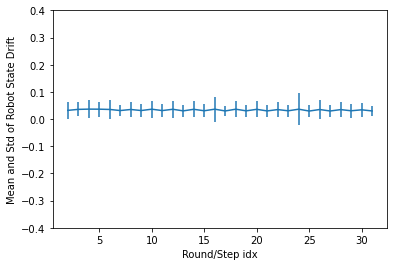

In [4]:
#Compute Mean error for success
success_mean_error = np.mean(success_error_all,axis=0)
success_std_error = np.std(success_error_all,axis=0)
stepIdx = np.array([i for i in range(2,32)])
print("mean error for sucess: ", success_mean_error)
print("std error for sucess: ", success_std_error)
fig=plt.figure();   ax = fig.gca()
plt.errorbar(stepIdx, success_mean_error, success_std_error)
ax.set_xlabel("Round/Step idx")
ax.set_ylabel("Mean and Std of Robot State Drift")
ax.set_ylim([-0.4,0.4])
plt.show()

[[0.0229]
 [0.0169]
 [0.0533]
 ...
 [0.0284]
 [0.0255]
 [0.0232]]
mean error for fail:  [0.0613 0.0381 0.0409 0.0379 0.0371 0.0359 0.0373 0.0358 0.0357 0.0365
 0.0372 0.0365 0.0374 0.0364 0.0373 0.0382 0.0363 0.0358 0.0375 0.0368
 0.0375 0.0365 0.0374 0.0373 0.0378 0.0374 0.0375 0.0373]
std error for fail:  [0.2054 0.0334 0.0323 0.0286 0.0309 0.028  0.0303 0.0268 0.0278 0.0286
 0.032  0.0289 0.0306 0.0281 0.0291 0.0315 0.0271 0.0272 0.0347 0.0281
 0.0293 0.0264 0.0291 0.0276 0.0286 0.0277 0.0277 0.027 ]


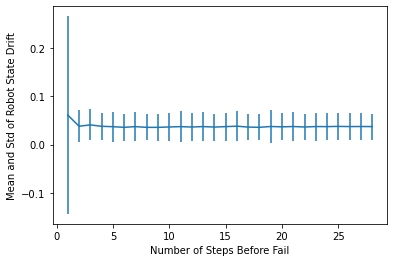

In [5]:
#Compute Mean error for failed
failed_mean_error = []
failed_std_error = []

for i in range(0,maxStepIndexbeforeFail):
    templist = []
    for j in range(len(failed_error_all)):
        if i <= len(failed_error_all[j]) - 1:
            templist.append(failed_error_all[j][i])
    
    if i == 0:
        print(np.sort((templist)))
    
    temp_mean = np.mean(templist)
    temp_std = np.std(templist)

    failed_mean_error.append(temp_mean)
    failed_std_error.append(temp_std)

failed_mean_error = np.array(failed_mean_error)
failed_std_error = np.array(failed_std_error)

print("mean error for fail: ", failed_mean_error)
print("std error for fail: ", failed_std_error)
fig=plt.figure();   ax = fig.gca()
stepIdx = np.array([i for i in range(1, maxStepIndexbeforeFail+1)])
plt.errorbar(stepIdx, failed_mean_error, failed_std_error)
ax.set_xlabel("Number of Steps Before Fail")
ax.set_ylabel("Mean and Std of Robot State Drift")
#ax.set_ylim([-0.4,0.4])
plt.show()